# Importing

In [1]:
import os
print(os.listdir("/kaggle/input/image-v2-c2-a/image_v2_2c_a"))

['normal', 'abnormal']


In [2]:
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm

import time
import random
import glob

import cv2
from PIL import Image

# Sample Images

* Normal

There are 4000 pictures of Normal Eyes.


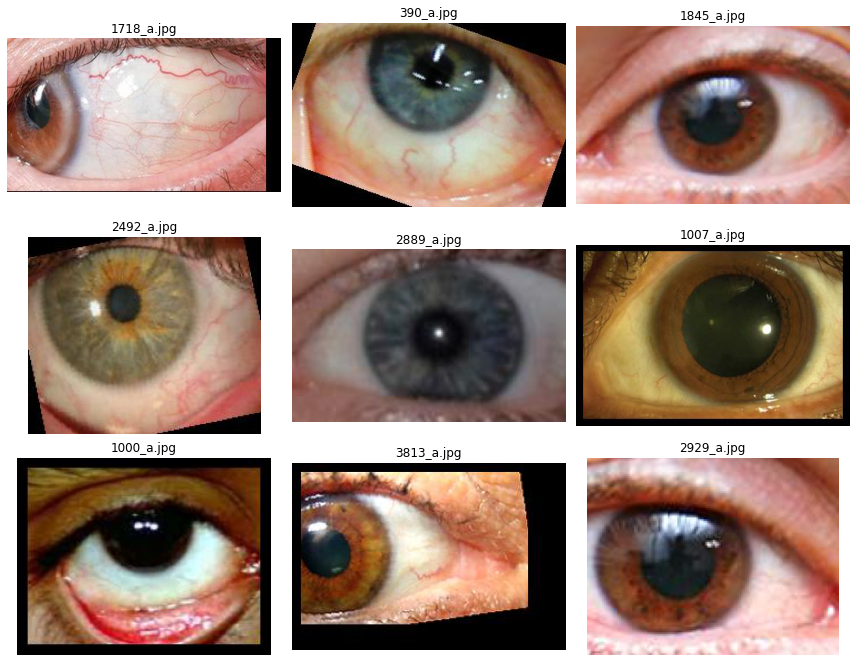

In [3]:
PATH1 = '/kaggle/input/image-v2-c2-a/image_v2_2c_a/normal/'
images = os.listdir(PATH1)
print(f'There are {len(os.listdir(PATH1))} pictures of Normal Eyes.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH1)))
    img = plt.imread(PATH1 + images[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

* Abnormal

There are 4000 pictures of Abnormal Eyes.


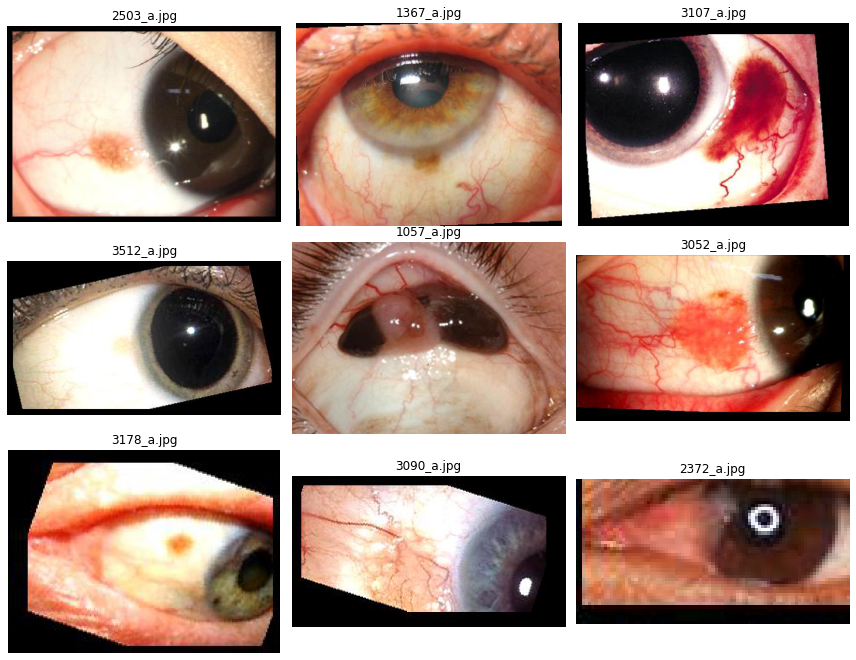

In [4]:
PATH2 = '/kaggle/input/image-v2-c2-a/image_v2_2c_a/abnormal/'
images2 = os.listdir(PATH2)
print(f'There are {len(os.listdir(PATH2))} pictures of Abnormal Eyes.')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,10))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(os.listdir(PATH2)))
    img = plt.imread(PATH2 + images2[rnd_indx])
    imgplot = axis.imshow(img)
    axis.set_title(images2[rnd_indx])
    axis.set_axis_off()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Image Preprocessing

In [5]:
batch_size = 32
batchSize = 64
imageSize = 64

# 64x64 images!
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('/kaggle/input/image-v2-c2-a/image_v2_2c_a', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [6]:
batch_size = 32
image_size = 64

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder('/kaggle/input/image-v2-c2-a/image_v2_2c_a', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

In [7]:
train_data

Dataset ImageFolder
    Number of datapoints: 8000
    Root location: /kaggle/input/image-v2-c2-a/image_v2_2c_a
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               RandomHorizontalFlip(p=0.5)
               RandomApply(
               p=0.2
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
           )
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

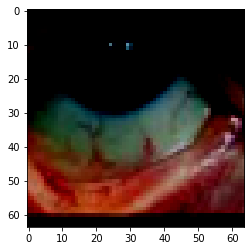

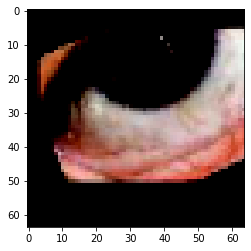

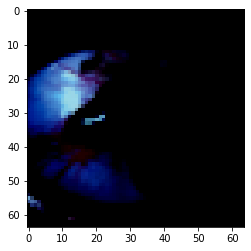

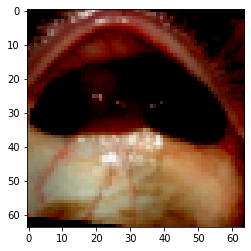

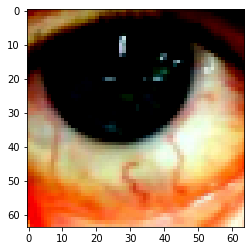

In [8]:
for i in range(5):
    plt.imshow(imgs[i])
    plt.show()

# Weights

In [9]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator

In [10]:
class G(nn.Module):
    def __init__(self):
        super(G, self).__init__()
        self.main = nn.Sequential(
                nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(512),
                nn.ReLU(True),
                nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(True),
                nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.ReLU(True),
                nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
                nn.Tanh()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output

netG = G()
netG.apply(weights_init)

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

# Discriminator

In [11]:
class D(nn.Module):
    def __init__(self):
        super(D, self).__init__()
        self.main = nn.Sequential(
                nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(128),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(512),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                nn.Sigmoid()
                )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1)
    
netD = D()
netD.apply(weights_init)

D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [12]:
class Generator(nn.Module):
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0), # Fully connected layer via convolution.
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img

    
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # FC with Conv.
        )

    def forward(self, imgs):
        logits = self.model(imgs)
        out = torch.sigmoid(logits)
    
        return out.view(-1, 1)

# Training

In [13]:
!mkdir results
!ls

mkdir: cannot create directory ‘results’: File exists
results


In [14]:
EPOCH = 5
LR = 0.0001
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(0.5, 0.999))

In [15]:
for epoch in range(EPOCH):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        
        real,_ = data
        input = Variable(real)
        target = Variable(torch.ones(input.size()[0]))
        output = netD(input)
        errD_real = criterion(output, target)
        
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1))
        fake = netG(noise)
        target = Variable(torch.zeros(input.size()[0]))
        output = netD(fake.detach())
        errD_fake = criterion(output, target)
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        netG.zero_grad()
        target = Variable(torch.ones(input.size()[0]))
        output = netD(fake)
        errG = criterion(output, target)
        errG.backward()
        optimizerG.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f; Loss_G: %.4f' % (epoch, EPOCH, i, len(dataloader), errD.item(), errG.item()))
        if i % 100 == 0:
            vutils.save_image(real, '%s/real_samples.png' % "./results", normalize=True)
            fake = netG(noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % ("./results", epoch), normalize=True)

[0/5][0/250] Loss_D: 2.0359; Loss_G: 2.6943
[0/5][1/250] Loss_D: 1.0612; Loss_G: 3.2934
[0/5][2/250] Loss_D: 0.7020; Loss_G: 3.6566
[0/5][3/250] Loss_D: 0.5762; Loss_G: 3.8550
[0/5][4/250] Loss_D: 0.5303; Loss_G: 3.9462
[0/5][5/250] Loss_D: 0.4290; Loss_G: 4.0451
[0/5][6/250] Loss_D: 0.4718; Loss_G: 3.9889
[0/5][7/250] Loss_D: 0.4258; Loss_G: 4.3570
[0/5][8/250] Loss_D: 0.3187; Loss_G: 4.4205
[0/5][9/250] Loss_D: 0.3405; Loss_G: 4.2002
[0/5][10/250] Loss_D: 0.3778; Loss_G: 4.5315
[0/5][11/250] Loss_D: 0.3403; Loss_G: 5.0639
[0/5][12/250] Loss_D: 0.3893; Loss_G: 4.8778
[0/5][13/250] Loss_D: 0.3319; Loss_G: 4.6179
[0/5][14/250] Loss_D: 0.2092; Loss_G: 4.8059
[0/5][15/250] Loss_D: 0.3118; Loss_G: 5.0868
[0/5][16/250] Loss_D: 0.2598; Loss_G: 5.0586
[0/5][17/250] Loss_D: 0.3097; Loss_G: 4.9250
[0/5][18/250] Loss_D: 0.2050; Loss_G: 5.1376
[0/5][19/250] Loss_D: 0.2254; Loss_G: 5.5487
[0/5][20/250] Loss_D: 0.2708; Loss_G: 5.3086
[0/5][21/250] Loss_D: 0.1819; Loss_G: 5.3724
[0/5][22/250] Loss_D

In [16]:
batch_size = 32
LR_G = 0.0005
LR_D = 0.0001

beta1 = 0.5
epochs = 100

real_label = 0.9
fake_label = 0
nz = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
netG = Generator(nz).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=LR_D, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR_G, betas=(beta1, 0.999))

fixed_noise = torch.randn(25, nz, 1, 1, device=device)

G_losses = []
D_losses = []
epoch_time = []

In [18]:
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH "+ str(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [19]:
def show_generated_img(n_images=5):
    sample = []
    for _ in range(n_images):
        noise = torch.randn(1, nz, 1, 1, device=device)
        gen_image = netG(noise).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        sample.append(gen_image)
    
    figure, axes = plt.subplots(1, len(sample), figsize = (64,64))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/250 [00:00<?, ?it/s]

[1/100][125/250] Loss_D: 1.7569 Loss_G: 0.7042 D(x): 0.3677 D(G(z)): 0.5465 / 0.4945
[1/100][250/250] Loss_D: 1.4804 Loss_G: 0.7874 D(x): 0.4253 D(G(z)): 0.4679 / 0.4491


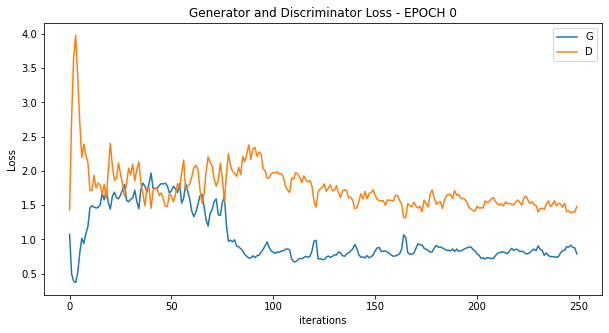

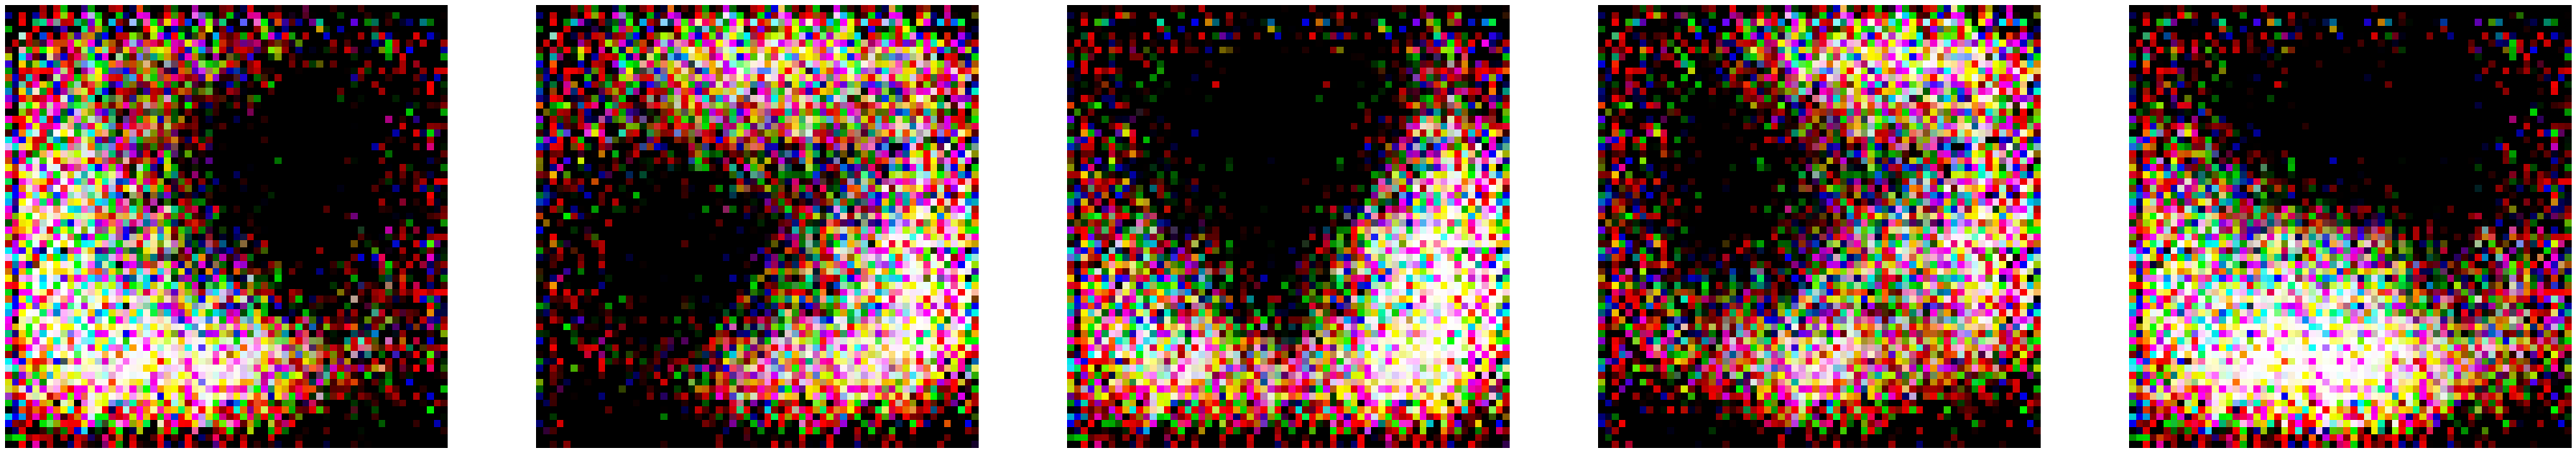

  0%|          | 0/250 [00:00<?, ?it/s]

[2/100][125/250] Loss_D: 1.4141 Loss_G: 0.8409 D(x): 0.4246 D(G(z)): 0.4384 / 0.4182
[2/100][250/250] Loss_D: 1.4458 Loss_G: 0.7811 D(x): 0.4165 D(G(z)): 0.4511 / 0.4491


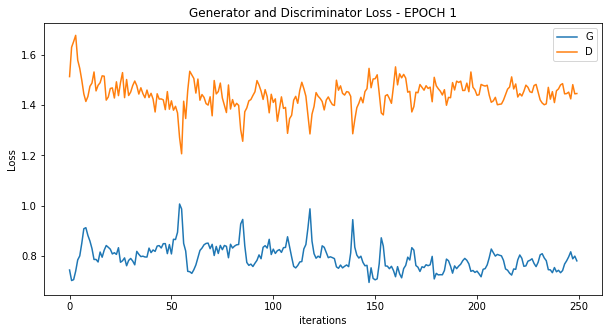

  0%|          | 0/250 [00:00<?, ?it/s]

[3/100][125/250] Loss_D: 1.4347 Loss_G: 0.7682 D(x): 0.4401 D(G(z)): 0.4666 / 0.4582
[3/100][250/250] Loss_D: 1.4147 Loss_G: 0.7704 D(x): 0.4396 D(G(z)): 0.4594 / 0.4550


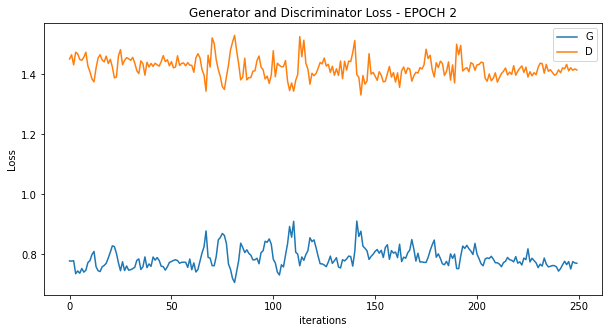

  0%|          | 0/250 [00:00<?, ?it/s]

[4/100][125/250] Loss_D: 1.4077 Loss_G: 0.7698 D(x): 0.4528 D(G(z)): 0.4648 / 0.4563
[4/100][250/250] Loss_D: 1.4062 Loss_G: 0.7748 D(x): 0.4509 D(G(z)): 0.4595 / 0.4569


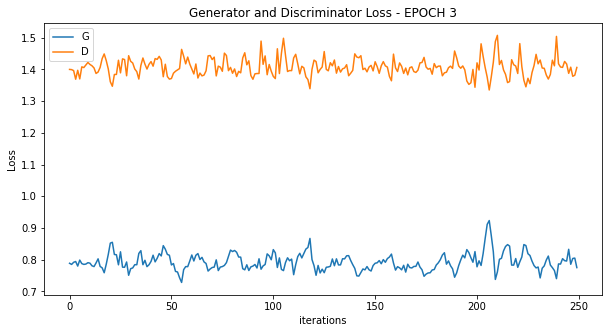

  0%|          | 0/250 [00:00<?, ?it/s]

[5/100][125/250] Loss_D: 1.3874 Loss_G: 0.7980 D(x): 0.4457 D(G(z)): 0.4472 / 0.4414
[5/100][250/250] Loss_D: 1.3942 Loss_G: 0.7808 D(x): 0.4468 D(G(z)): 0.4541 / 0.4493


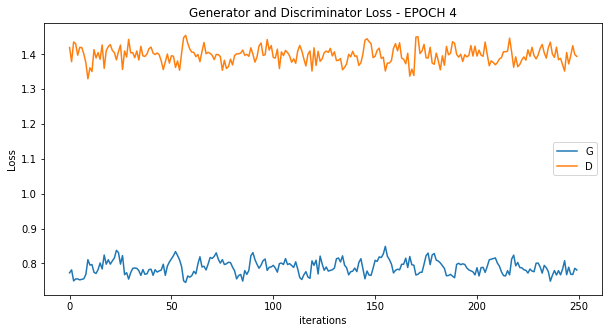

  0%|          | 0/250 [00:00<?, ?it/s]

[6/100][125/250] Loss_D: 1.4394 Loss_G: 0.7667 D(x): 0.4300 D(G(z)): 0.4610 / 0.4577
[6/100][250/250] Loss_D: 1.3641 Loss_G: 0.8048 D(x): 0.4558 D(G(z)): 0.4459 / 0.4369


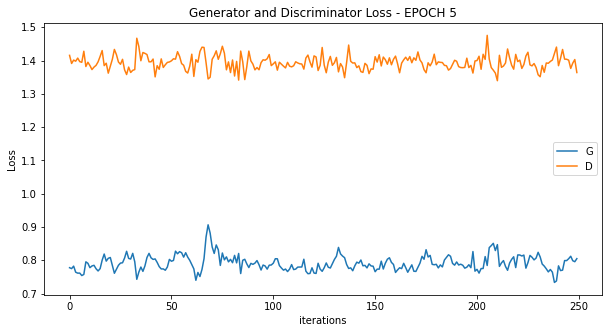

  0%|          | 0/250 [00:00<?, ?it/s]

[7/100][125/250] Loss_D: 1.3711 Loss_G: 0.7976 D(x): 0.4469 D(G(z)): 0.4421 / 0.4410
[7/100][250/250] Loss_D: 1.3900 Loss_G: 0.7961 D(x): 0.4500 D(G(z)): 0.4562 / 0.4417


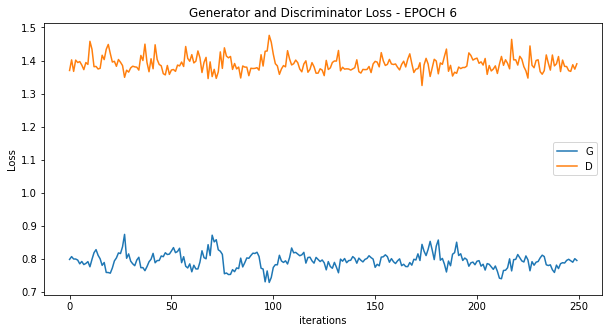

  0%|          | 0/250 [00:00<?, ?it/s]

[8/100][125/250] Loss_D: 1.4152 Loss_G: 0.8356 D(x): 0.4292 D(G(z)): 0.4436 / 0.4234
[8/100][250/250] Loss_D: 1.3859 Loss_G: 0.7934 D(x): 0.4458 D(G(z)): 0.4481 / 0.4430


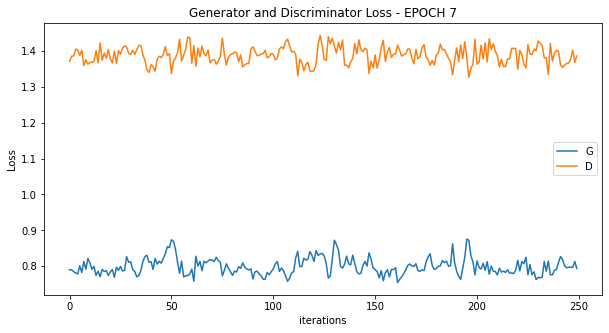

  0%|          | 0/250 [00:00<?, ?it/s]

[9/100][125/250] Loss_D: 1.3672 Loss_G: 0.8313 D(x): 0.4342 D(G(z)): 0.4274 / 0.4226
[9/100][250/250] Loss_D: 1.3905 Loss_G: 0.7896 D(x): 0.4427 D(G(z)): 0.4478 / 0.4452


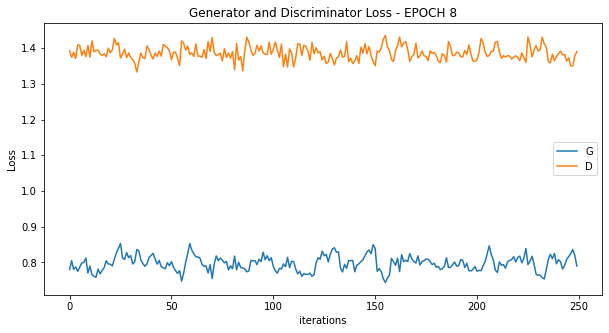

  0%|          | 0/250 [00:00<?, ?it/s]

[10/100][125/250] Loss_D: 1.3808 Loss_G: 0.8159 D(x): 0.4489 D(G(z)): 0.4484 / 0.4313
[10/100][250/250] Loss_D: 1.4180 Loss_G: 0.7844 D(x): 0.4478 D(G(z)): 0.4663 / 0.4481


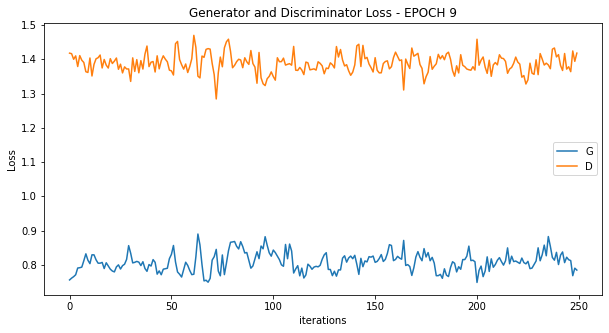

  0%|          | 0/250 [00:00<?, ?it/s]

[11/100][125/250] Loss_D: 1.4037 Loss_G: 0.8161 D(x): 0.4343 D(G(z)): 0.4468 / 0.4310
[11/100][250/250] Loss_D: 1.3734 Loss_G: 0.8099 D(x): 0.4469 D(G(z)): 0.4427 / 0.4344


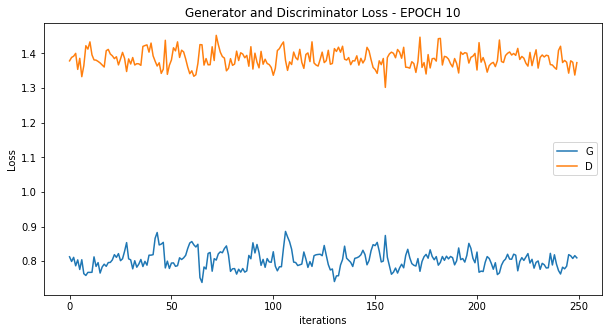

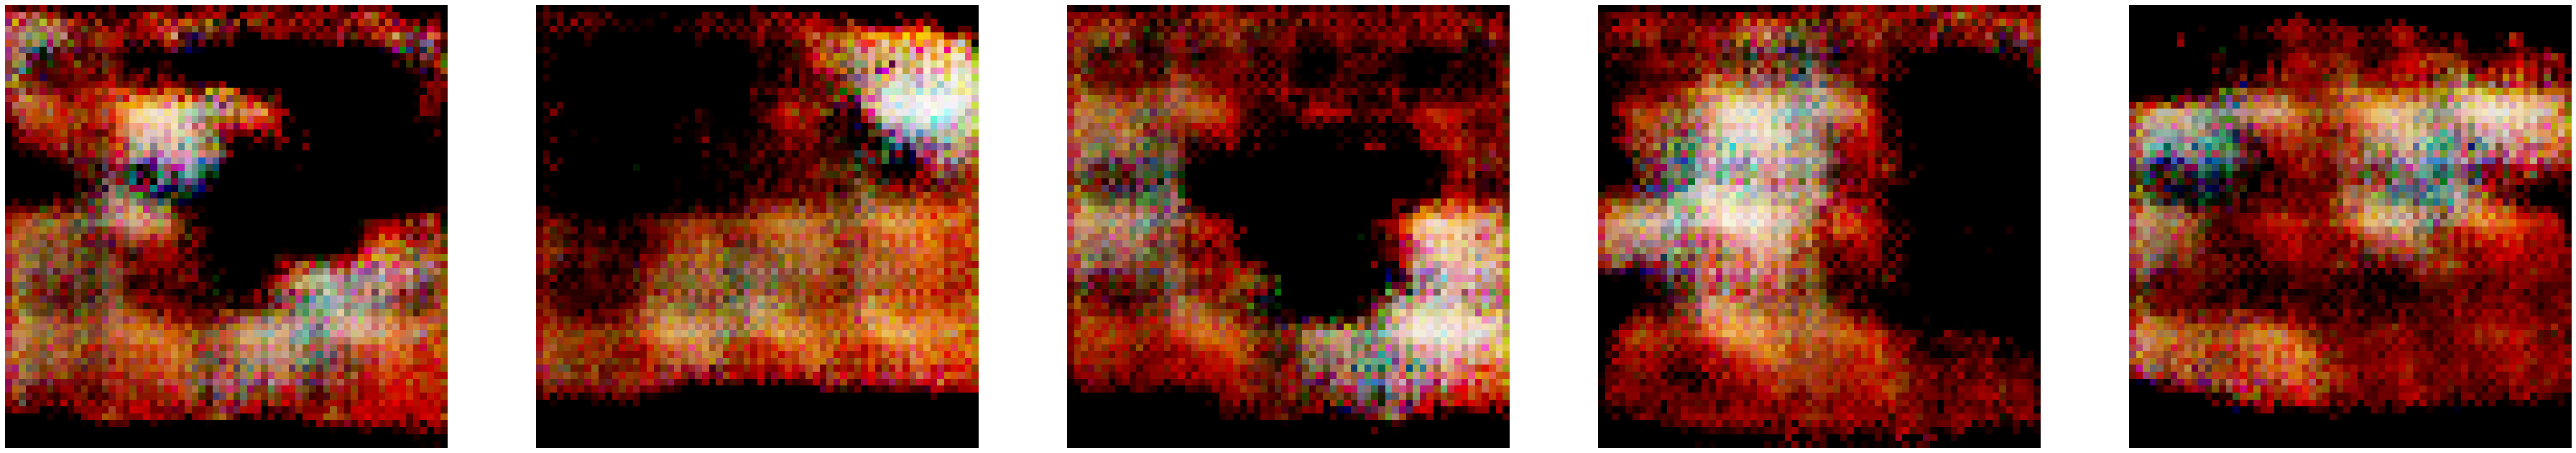

  0%|          | 0/250 [00:00<?, ?it/s]

[12/100][125/250] Loss_D: 1.4176 Loss_G: 0.7871 D(x): 0.4426 D(G(z)): 0.4626 / 0.4466
[12/100][250/250] Loss_D: 1.3789 Loss_G: 0.8055 D(x): 0.4507 D(G(z)): 0.4467 / 0.4377


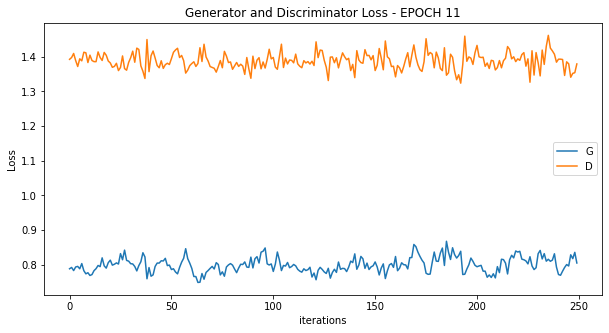

  0%|          | 0/250 [00:00<?, ?it/s]

[13/100][125/250] Loss_D: 1.3634 Loss_G: 0.8380 D(x): 0.4451 D(G(z)): 0.4346 / 0.4210
[13/100][250/250] Loss_D: 1.3497 Loss_G: 0.8416 D(x): 0.4502 D(G(z)): 0.4322 / 0.4188


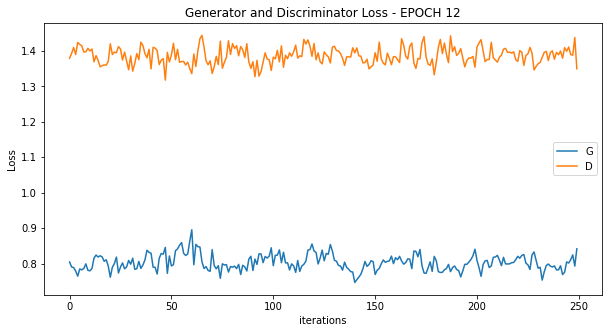

  0%|          | 0/250 [00:00<?, ?it/s]

[14/100][125/250] Loss_D: 1.4034 Loss_G: 0.7974 D(x): 0.4332 D(G(z)): 0.4429 / 0.4424
[14/100][250/250] Loss_D: 1.3787 Loss_G: 0.7863 D(x): 0.4614 D(G(z)): 0.4599 / 0.4472


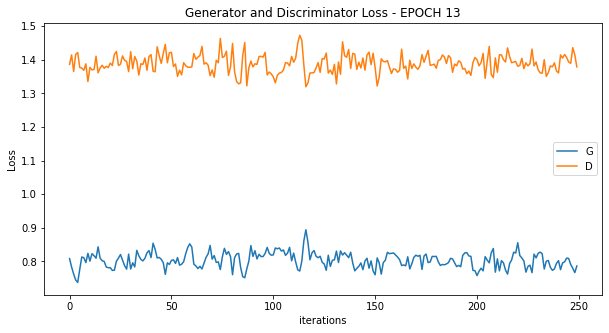

  0%|          | 0/250 [00:00<?, ?it/s]

[15/100][125/250] Loss_D: 1.3671 Loss_G: 0.8157 D(x): 0.4543 D(G(z)): 0.4461 / 0.4313
[15/100][250/250] Loss_D: 1.3829 Loss_G: 0.7872 D(x): 0.4579 D(G(z)): 0.4605 / 0.4457


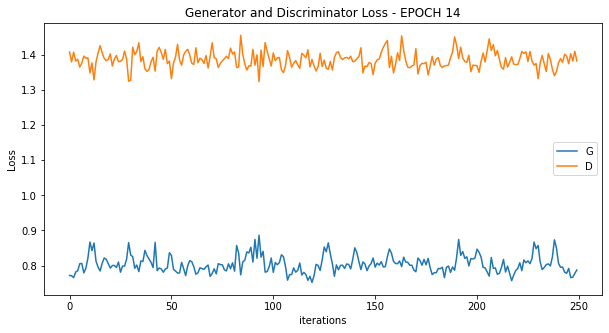

  0%|          | 0/250 [00:00<?, ?it/s]

[16/100][125/250] Loss_D: 1.3888 Loss_G: 0.8159 D(x): 0.4378 D(G(z)): 0.4395 / 0.4320
[16/100][250/250] Loss_D: 1.3688 Loss_G: 0.8123 D(x): 0.4569 D(G(z)): 0.4506 / 0.4339


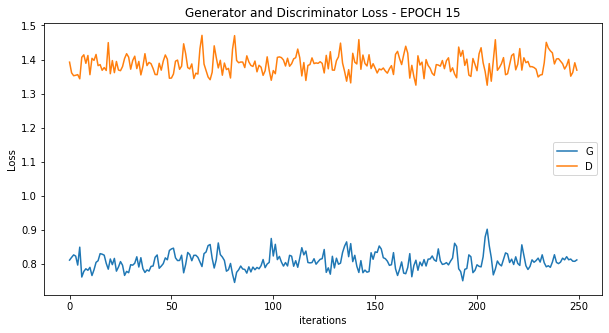

  0%|          | 0/250 [00:00<?, ?it/s]

[17/100][125/250] Loss_D: 1.4057 Loss_G: 0.8007 D(x): 0.4377 D(G(z)): 0.4520 / 0.4390
[17/100][250/250] Loss_D: 1.3748 Loss_G: 0.7804 D(x): 0.4753 D(G(z)): 0.4698 / 0.4512


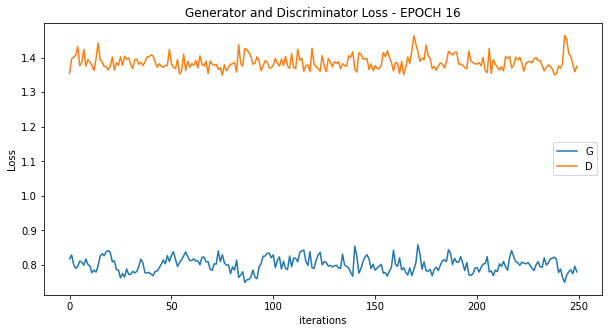

  0%|          | 0/250 [00:00<?, ?it/s]

[18/100][125/250] Loss_D: 1.4079 Loss_G: 0.7765 D(x): 0.4527 D(G(z)): 0.4659 / 0.4522
[18/100][250/250] Loss_D: 1.4056 Loss_G: 0.8012 D(x): 0.4380 D(G(z)): 0.4510 / 0.4390


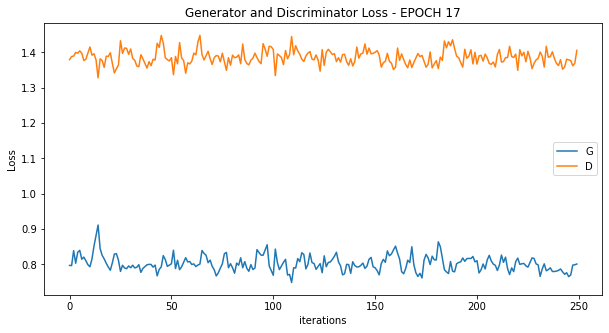

  0%|          | 0/250 [00:00<?, ?it/s]

[19/100][125/250] Loss_D: 1.4054 Loss_G: 0.7776 D(x): 0.4542 D(G(z)): 0.4674 / 0.4511
[19/100][250/250] Loss_D: 1.3819 Loss_G: 0.8081 D(x): 0.4603 D(G(z)): 0.4566 / 0.4394


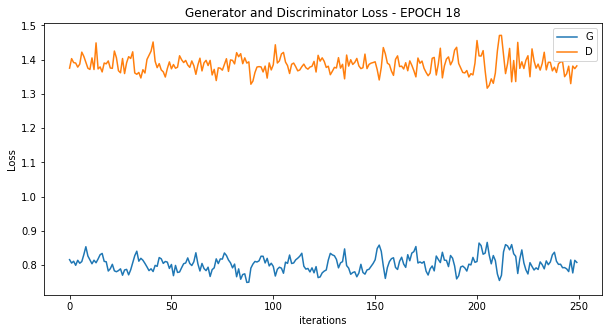

  0%|          | 0/250 [00:00<?, ?it/s]

[20/100][125/250] Loss_D: 1.3826 Loss_G: 0.8063 D(x): 0.4569 D(G(z)): 0.4559 / 0.4383
[20/100][250/250] Loss_D: 1.3459 Loss_G: 0.8109 D(x): 0.4605 D(G(z)): 0.4418 / 0.4340


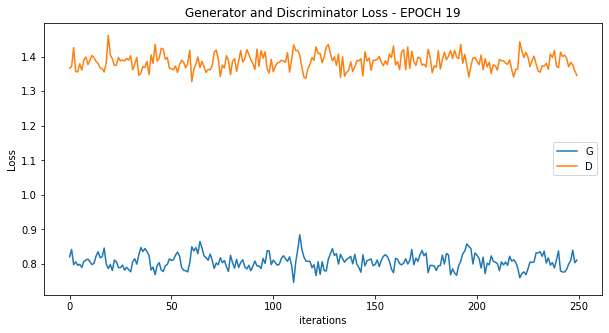

  0%|          | 0/250 [00:00<?, ?it/s]

[21/100][125/250] Loss_D: 1.3765 Loss_G: 0.8219 D(x): 0.4331 D(G(z)): 0.4299 / 0.4284
[21/100][250/250] Loss_D: 1.3703 Loss_G: 0.8021 D(x): 0.4688 D(G(z)): 0.4609 / 0.4394


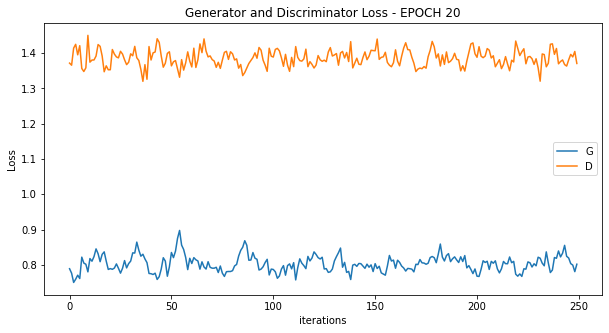

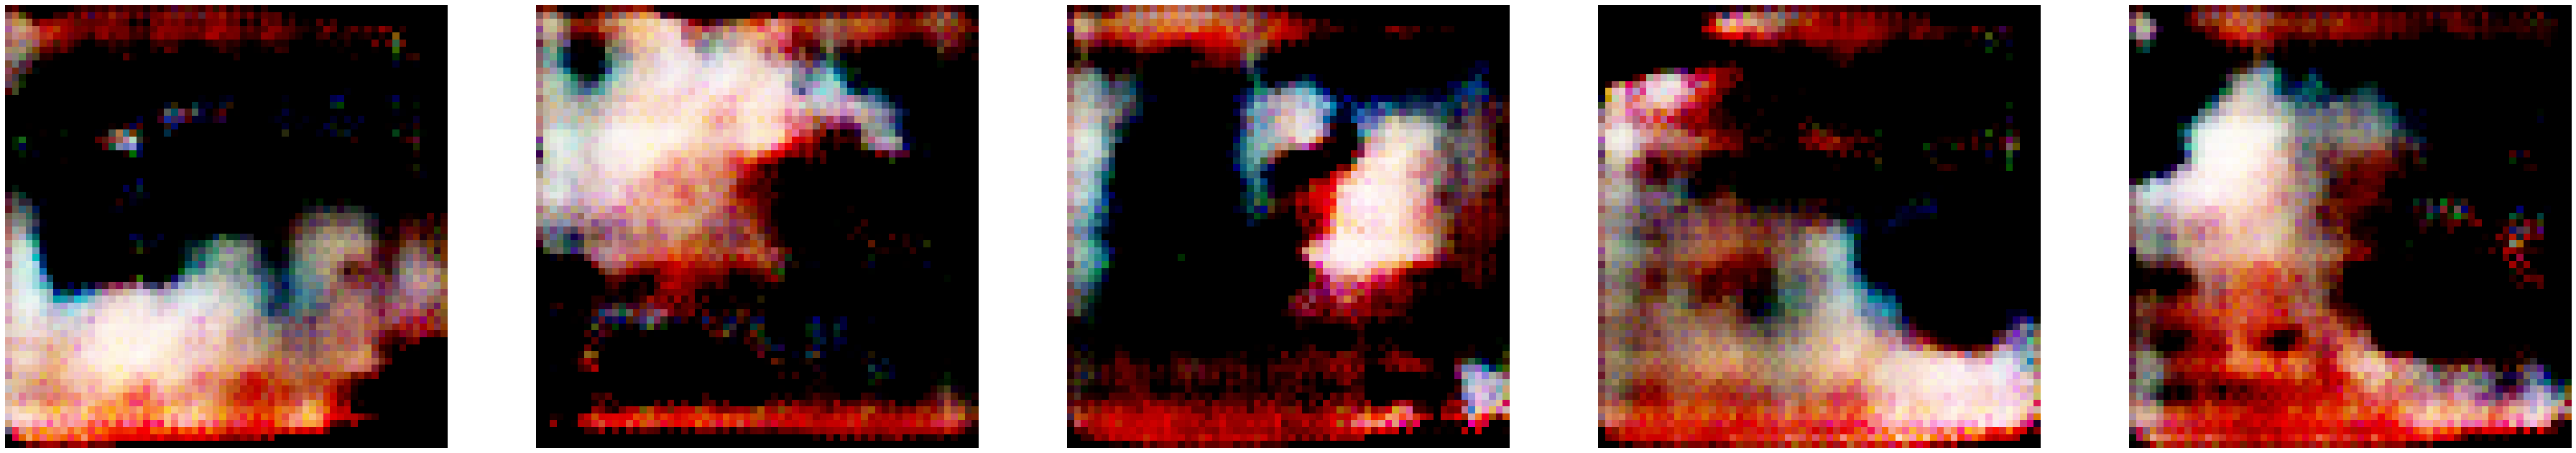

  0%|          | 0/250 [00:00<?, ?it/s]

[22/100][125/250] Loss_D: 1.3870 Loss_G: 0.8455 D(x): 0.4319 D(G(z)): 0.4356 / 0.4158
[22/100][250/250] Loss_D: 1.3897 Loss_G: 0.7891 D(x): 0.4555 D(G(z)): 0.4608 / 0.4447


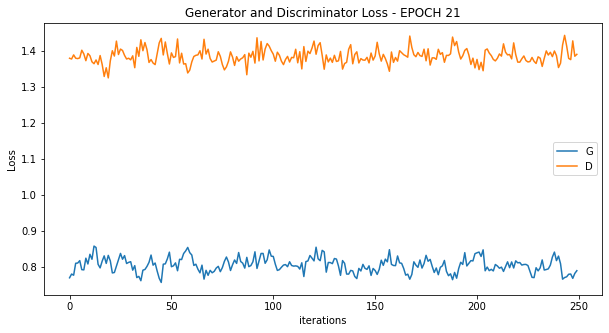

  0%|          | 0/250 [00:00<?, ?it/s]

[23/100][125/250] Loss_D: 1.3352 Loss_G: 0.7925 D(x): 0.4820 D(G(z)): 0.4561 / 0.4437
[23/100][250/250] Loss_D: 1.3902 Loss_G: 0.7946 D(x): 0.4428 D(G(z)): 0.4480 / 0.4419


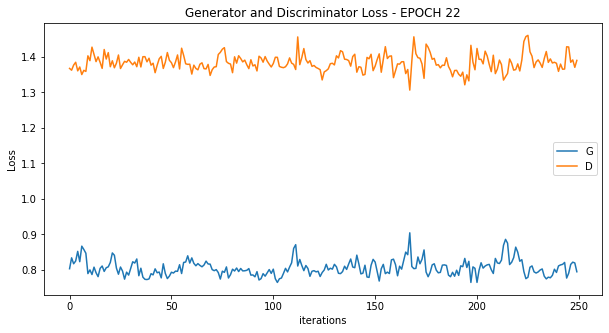

  0%|          | 0/250 [00:00<?, ?it/s]

[24/100][125/250] Loss_D: 1.3798 Loss_G: 0.7944 D(x): 0.4639 D(G(z)): 0.4614 / 0.4431
[24/100][250/250] Loss_D: 1.3712 Loss_G: 0.8191 D(x): 0.4564 D(G(z)): 0.4496 / 0.4313


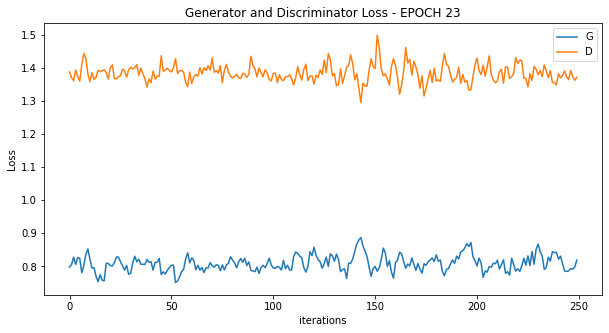

  0%|          | 0/250 [00:00<?, ?it/s]

[25/100][125/250] Loss_D: 1.3682 Loss_G: 0.7938 D(x): 0.4598 D(G(z)): 0.4524 / 0.4429
[25/100][250/250] Loss_D: 1.3924 Loss_G: 0.7837 D(x): 0.4627 D(G(z)): 0.4673 / 0.4486


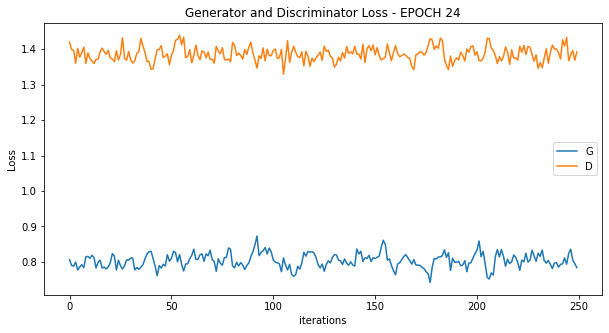

  0%|          | 0/250 [00:00<?, ?it/s]

[26/100][125/250] Loss_D: 1.3681 Loss_G: 0.7913 D(x): 0.4626 D(G(z)): 0.4541 / 0.4447
[26/100][250/250] Loss_D: 1.4160 Loss_G: 0.8095 D(x): 0.4339 D(G(z)): 0.4527 / 0.4342


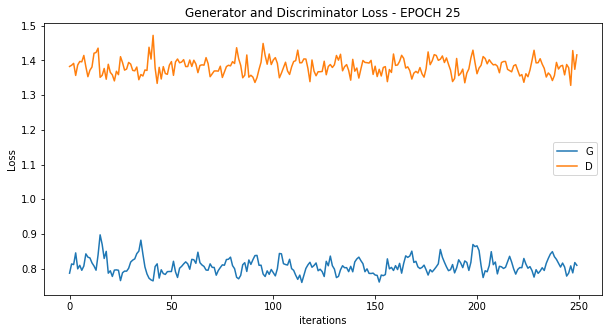

  0%|          | 0/250 [00:00<?, ?it/s]

[27/100][125/250] Loss_D: 1.3897 Loss_G: 0.8079 D(x): 0.4523 D(G(z)): 0.4551 / 0.4351
[27/100][250/250] Loss_D: 1.3801 Loss_G: 0.8287 D(x): 0.4495 D(G(z)): 0.4487 / 0.4254


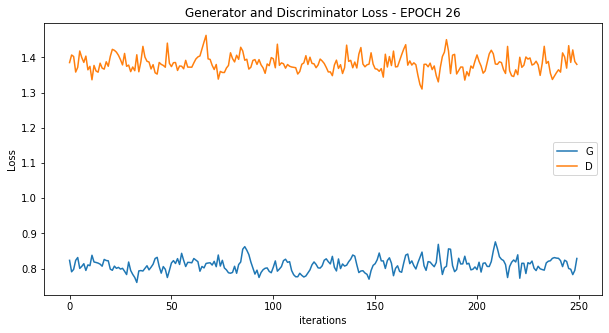

  0%|          | 0/250 [00:00<?, ?it/s]

[28/100][125/250] Loss_D: 1.3582 Loss_G: 0.8320 D(x): 0.4533 D(G(z)): 0.4410 / 0.4244
[28/100][250/250] Loss_D: 1.3696 Loss_G: 0.8261 D(x): 0.4440 D(G(z)): 0.4379 / 0.4258


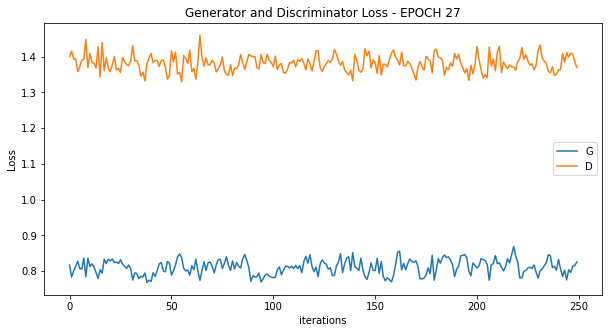

  0%|          | 0/250 [00:00<?, ?it/s]

[29/100][125/250] Loss_D: 1.3810 Loss_G: 0.8080 D(x): 0.4551 D(G(z)): 0.4539 / 0.4358
[29/100][250/250] Loss_D: 1.4207 Loss_G: 0.7901 D(x): 0.4539 D(G(z)): 0.4742 / 0.4449


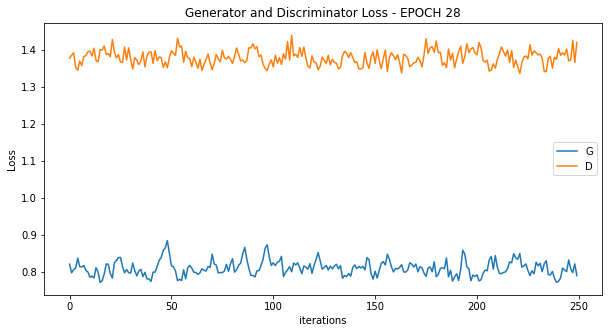

  0%|          | 0/250 [00:00<?, ?it/s]

[30/100][125/250] Loss_D: 1.3843 Loss_G: 0.8083 D(x): 0.4460 D(G(z)): 0.4477 / 0.4354
[30/100][250/250] Loss_D: 1.3602 Loss_G: 0.8118 D(x): 0.4594 D(G(z)): 0.4480 / 0.4336


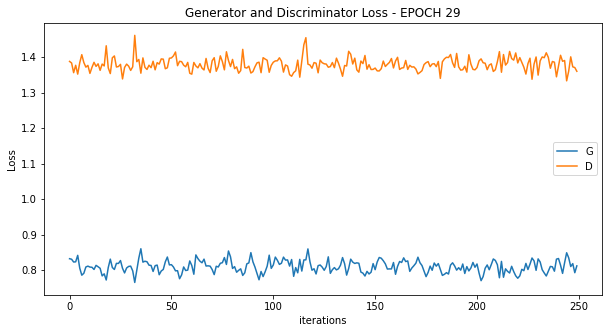

  0%|          | 0/250 [00:00<?, ?it/s]

[31/100][125/250] Loss_D: 1.3703 Loss_G: 0.8276 D(x): 0.4382 D(G(z)): 0.4320 / 0.4246
[31/100][250/250] Loss_D: 1.3402 Loss_G: 0.8376 D(x): 0.4585 D(G(z)): 0.4363 / 0.4209


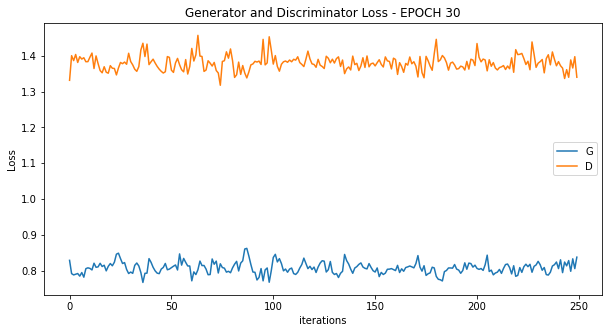

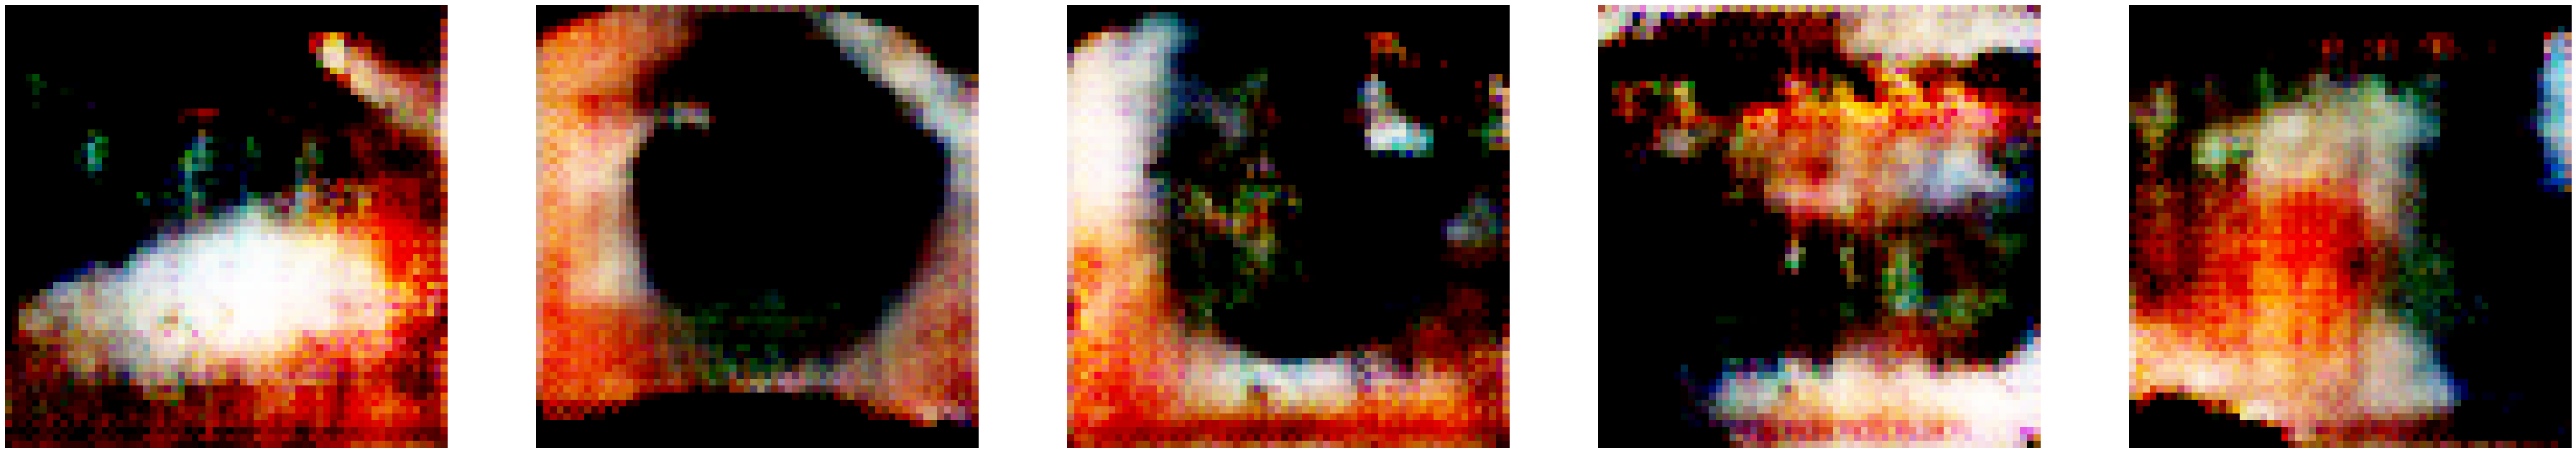

  0%|          | 0/250 [00:00<?, ?it/s]

[32/100][125/250] Loss_D: 1.4159 Loss_G: 0.7836 D(x): 0.4514 D(G(z)): 0.4689 / 0.4485
[32/100][250/250] Loss_D: 1.3520 Loss_G: 0.8383 D(x): 0.4538 D(G(z)): 0.4384 / 0.4202


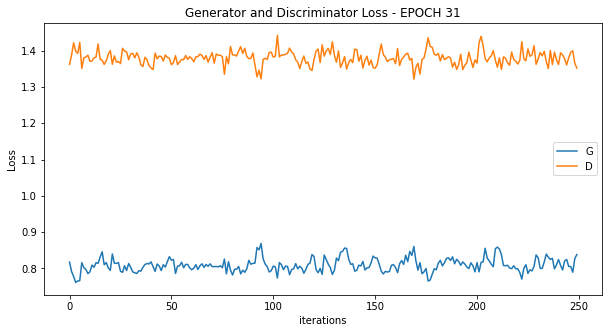

  0%|          | 0/250 [00:00<?, ?it/s]

[33/100][125/250] Loss_D: 1.3578 Loss_G: 0.8195 D(x): 0.4556 D(G(z)): 0.4434 / 0.4294
[33/100][250/250] Loss_D: 1.3702 Loss_G: 0.8309 D(x): 0.4421 D(G(z)): 0.4365 / 0.4229


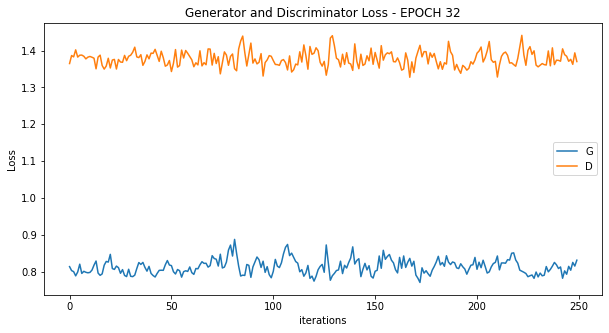

  0%|          | 0/250 [00:00<?, ?it/s]

[34/100][125/250] Loss_D: 1.3924 Loss_G: 0.7907 D(x): 0.4605 D(G(z)): 0.4665 / 0.4446
[34/100][250/250] Loss_D: 1.3638 Loss_G: 0.8260 D(x): 0.4515 D(G(z)): 0.4408 / 0.4271


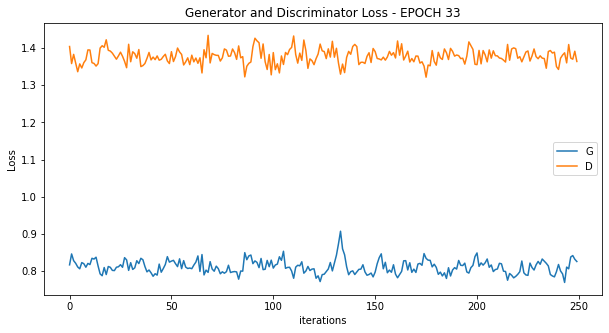

  0%|          | 0/250 [00:00<?, ?it/s]

[35/100][125/250] Loss_D: 1.3809 Loss_G: 0.7914 D(x): 0.4524 D(G(z)): 0.4514 / 0.4446
[35/100][250/250] Loss_D: 1.3506 Loss_G: 0.8215 D(x): 0.4525 D(G(z)): 0.4352 / 0.4284


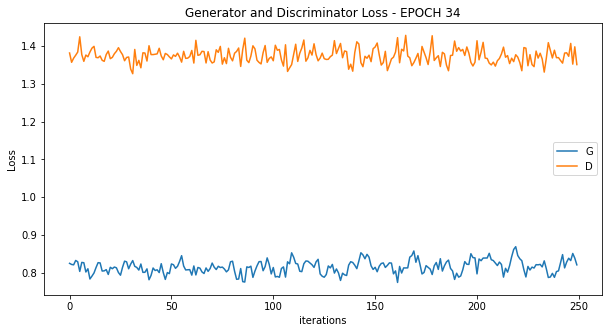

  0%|          | 0/250 [00:00<?, ?it/s]

[36/100][125/250] Loss_D: 1.3929 Loss_G: 0.8189 D(x): 0.4349 D(G(z)): 0.4409 / 0.4308
[36/100][250/250] Loss_D: 1.4019 Loss_G: 0.8025 D(x): 0.4516 D(G(z)): 0.4612 / 0.4397


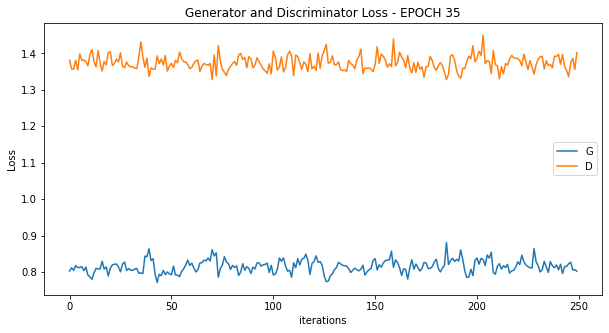

  0%|          | 0/250 [00:00<?, ?it/s]

[37/100][125/250] Loss_D: 1.3558 Loss_G: 0.8420 D(x): 0.4552 D(G(z)): 0.4398 / 0.4182
[37/100][250/250] Loss_D: 1.3578 Loss_G: 0.8314 D(x): 0.4481 D(G(z)): 0.4359 / 0.4225


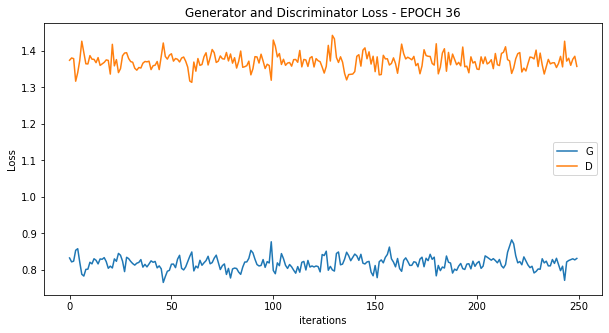

  0%|          | 0/250 [00:00<?, ?it/s]

[38/100][125/250] Loss_D: 1.3779 Loss_G: 0.8319 D(x): 0.4363 D(G(z)): 0.4329 / 0.4235
[38/100][250/250] Loss_D: 1.3569 Loss_G: 0.8383 D(x): 0.4517 D(G(z)): 0.4391 / 0.4199


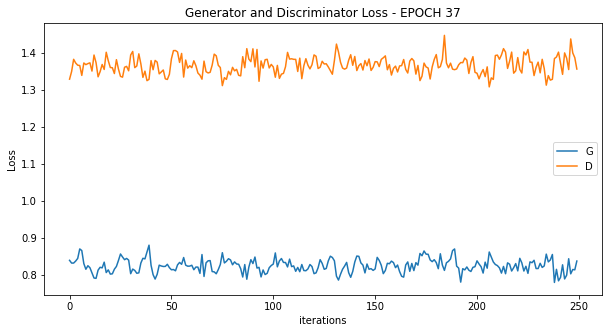

  0%|          | 0/250 [00:00<?, ?it/s]

[39/100][125/250] Loss_D: 1.3276 Loss_G: 0.8247 D(x): 0.4811 D(G(z)): 0.4475 / 0.4278
[39/100][250/250] Loss_D: 1.3880 Loss_G: 0.8297 D(x): 0.4324 D(G(z)): 0.4352 / 0.4241


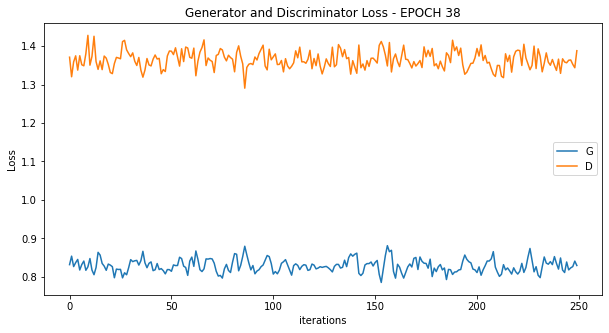

  0%|          | 0/250 [00:00<?, ?it/s]

[40/100][125/250] Loss_D: 1.3793 Loss_G: 0.8138 D(x): 0.4454 D(G(z)): 0.4430 / 0.4335
[40/100][250/250] Loss_D: 1.3735 Loss_G: 0.8128 D(x): 0.4558 D(G(z)): 0.4516 / 0.4326


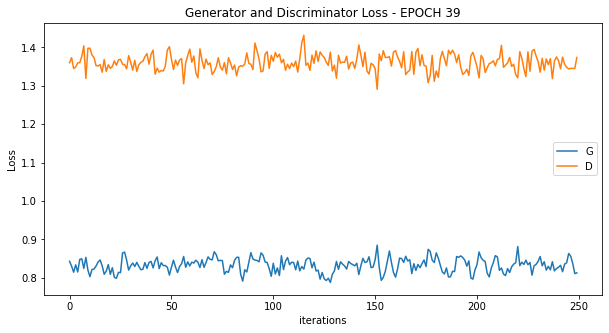

  0%|          | 0/250 [00:00<?, ?it/s]

[41/100][125/250] Loss_D: 1.3533 Loss_G: 0.8491 D(x): 0.4560 D(G(z)): 0.4396 / 0.4144
[41/100][250/250] Loss_D: 1.3319 Loss_G: 0.8645 D(x): 0.4532 D(G(z)): 0.4241 / 0.4087


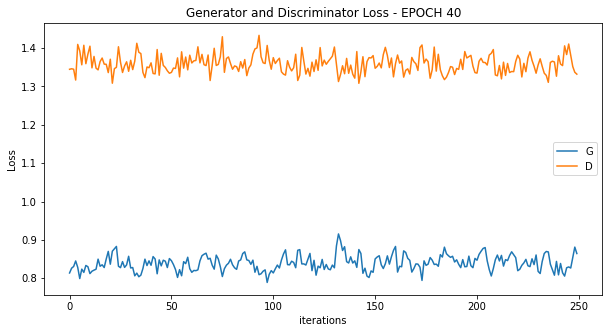

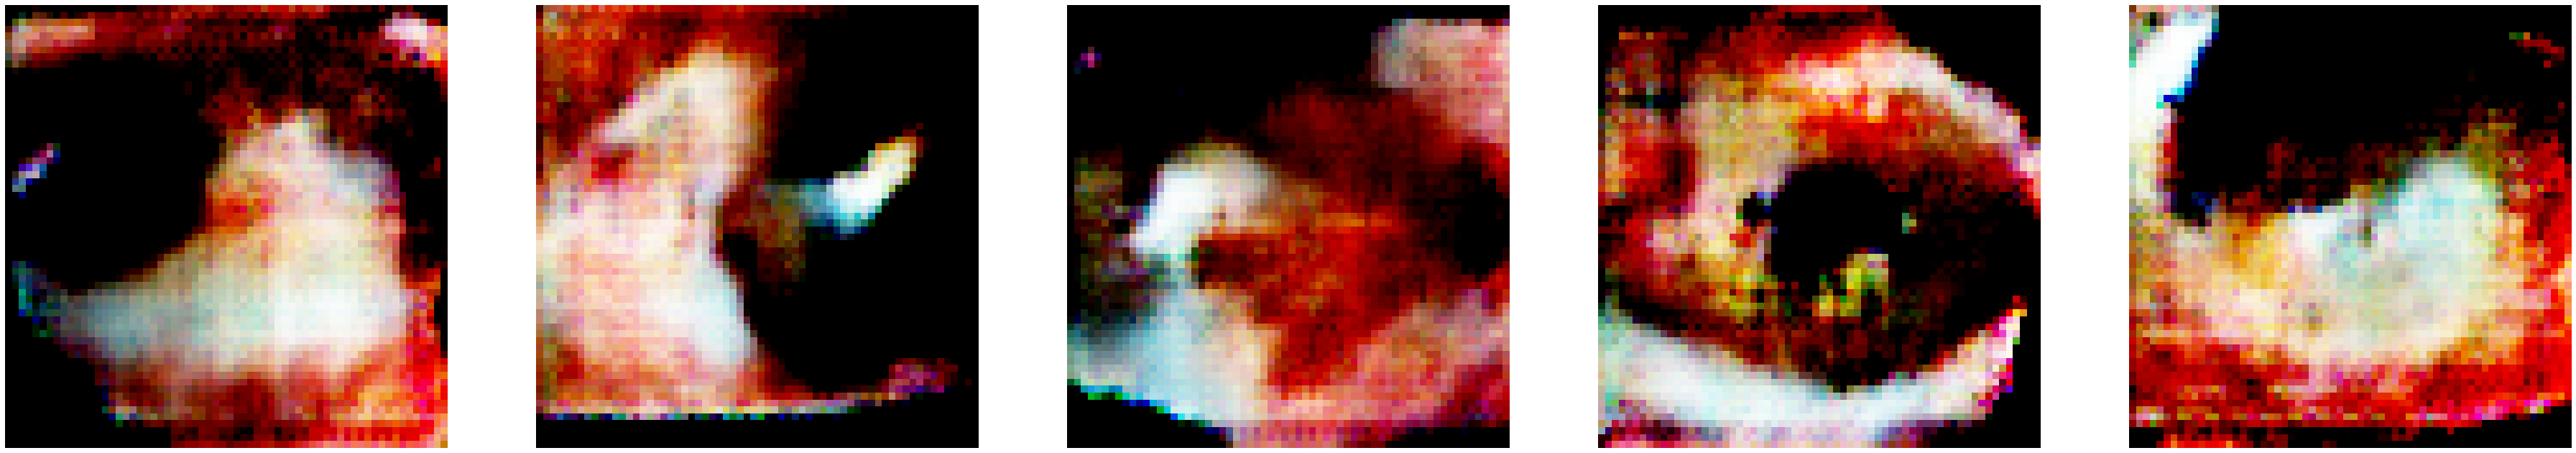

  0%|          | 0/250 [00:00<?, ?it/s]

[42/100][125/250] Loss_D: 1.3276 Loss_G: 0.8867 D(x): 0.4614 D(G(z)): 0.4300 / 0.3985
[42/100][250/250] Loss_D: 1.3729 Loss_G: 0.8561 D(x): 0.4450 D(G(z)): 0.4396 / 0.4107


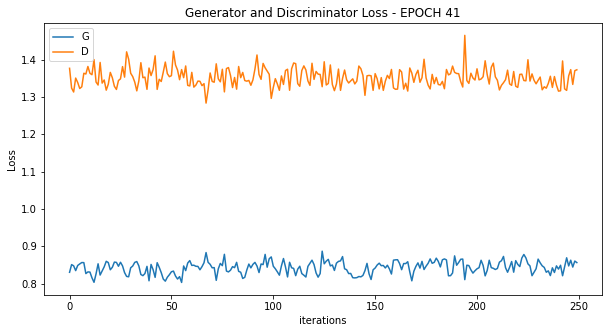

  0%|          | 0/250 [00:00<?, ?it/s]

[43/100][125/250] Loss_D: 1.3566 Loss_G: 0.8460 D(x): 0.4463 D(G(z)): 0.4301 / 0.4173
[43/100][250/250] Loss_D: 1.3327 Loss_G: 0.8733 D(x): 0.4524 D(G(z)): 0.4228 / 0.4049


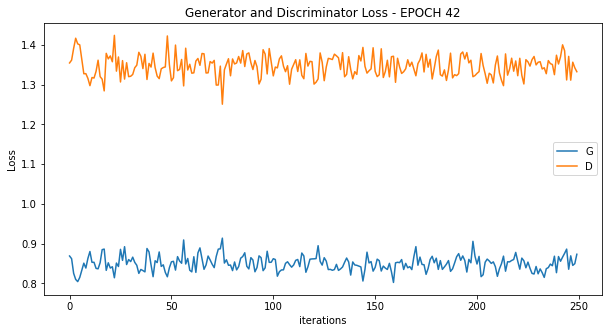

  0%|          | 0/250 [00:00<?, ?it/s]

[44/100][125/250] Loss_D: 1.3676 Loss_G: 0.8515 D(x): 0.4530 D(G(z)): 0.4424 / 0.4146
[44/100][250/250] Loss_D: 1.3588 Loss_G: 0.8607 D(x): 0.4428 D(G(z)): 0.4273 / 0.4103


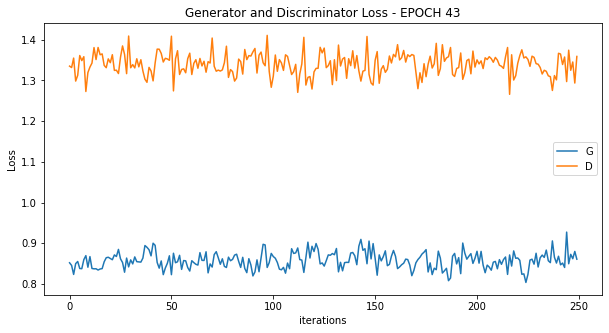

  0%|          | 0/250 [00:00<?, ?it/s]

[45/100][125/250] Loss_D: 1.3868 Loss_G: 0.8749 D(x): 0.4173 D(G(z)): 0.4124 / 0.4049
[45/100][250/250] Loss_D: 1.3223 Loss_G: 0.8712 D(x): 0.4737 D(G(z)): 0.4360 / 0.4075


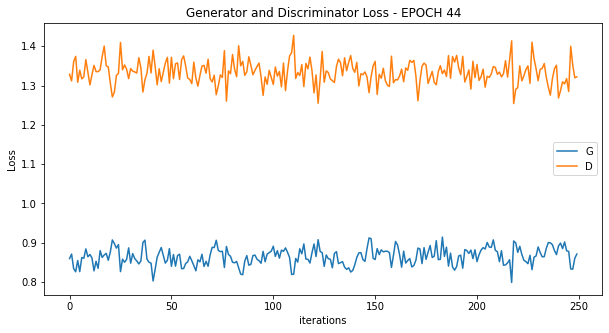

  0%|          | 0/250 [00:00<?, ?it/s]

[46/100][125/250] Loss_D: 1.3318 Loss_G: 0.8850 D(x): 0.4477 D(G(z)): 0.4166 / 0.4002
[46/100][250/250] Loss_D: 1.3135 Loss_G: 0.8871 D(x): 0.4713 D(G(z)): 0.4302 / 0.3979


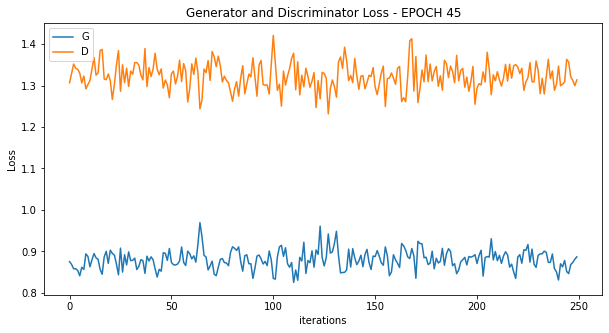

  0%|          | 0/250 [00:00<?, ?it/s]

[47/100][125/250] Loss_D: 1.3369 Loss_G: 0.9008 D(x): 0.4481 D(G(z)): 0.4181 / 0.3937
[47/100][250/250] Loss_D: 1.3597 Loss_G: 0.8711 D(x): 0.4494 D(G(z)): 0.4305 / 0.4058


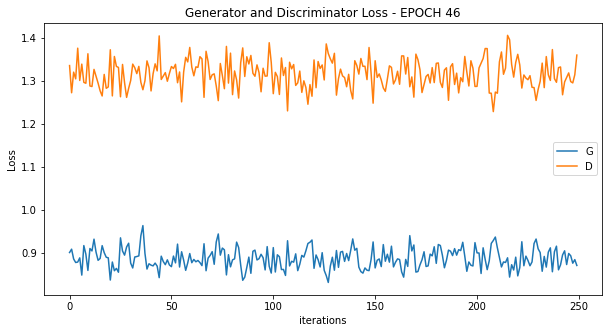

  0%|          | 0/250 [00:00<?, ?it/s]

[48/100][125/250] Loss_D: 1.1761 Loss_G: 0.9753 D(x): 0.5382 D(G(z)): 0.4089 / 0.3601
[48/100][250/250] Loss_D: 1.2625 Loss_G: 0.9252 D(x): 0.4892 D(G(z)): 0.4124 / 0.3818


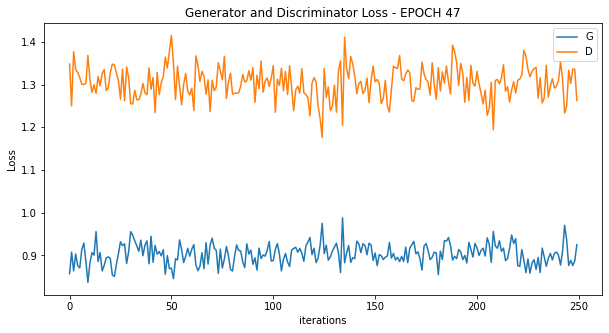

  0%|          | 0/250 [00:00<?, ?it/s]

[49/100][125/250] Loss_D: 1.3232 Loss_G: 0.8874 D(x): 0.4812 D(G(z)): 0.4397 / 0.3981
[49/100][250/250] Loss_D: 1.2857 Loss_G: 0.9097 D(x): 0.5010 D(G(z)): 0.4385 / 0.3875


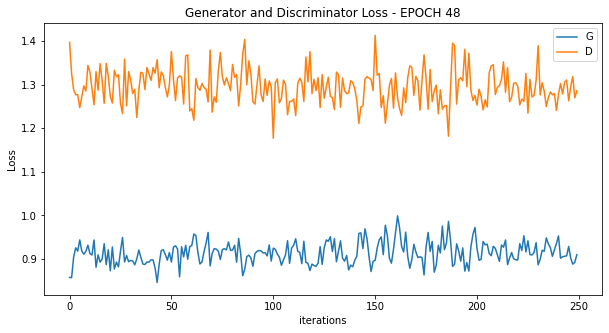

  0%|          | 0/250 [00:00<?, ?it/s]

[50/100][125/250] Loss_D: 1.3115 Loss_G: 0.9175 D(x): 0.4586 D(G(z)): 0.4108 / 0.3861
[50/100][250/250] Loss_D: 1.2997 Loss_G: 0.9581 D(x): 0.4776 D(G(z)): 0.4233 / 0.3702


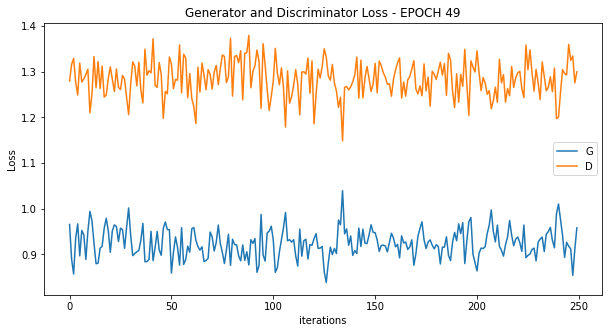

  0%|          | 0/250 [00:00<?, ?it/s]

[51/100][125/250] Loss_D: 1.2852 Loss_G: 0.9277 D(x): 0.4709 D(G(z)): 0.4080 / 0.3843
[51/100][250/250] Loss_D: 1.2173 Loss_G: 0.9692 D(x): 0.5220 D(G(z)): 0.4115 / 0.3668


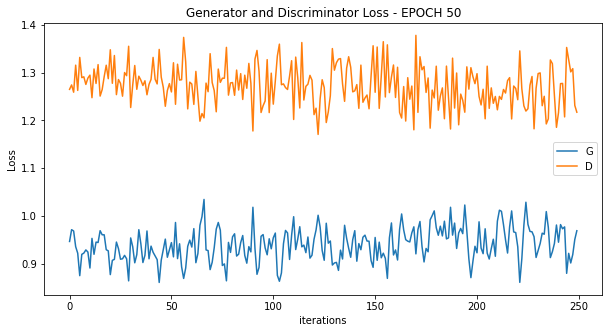

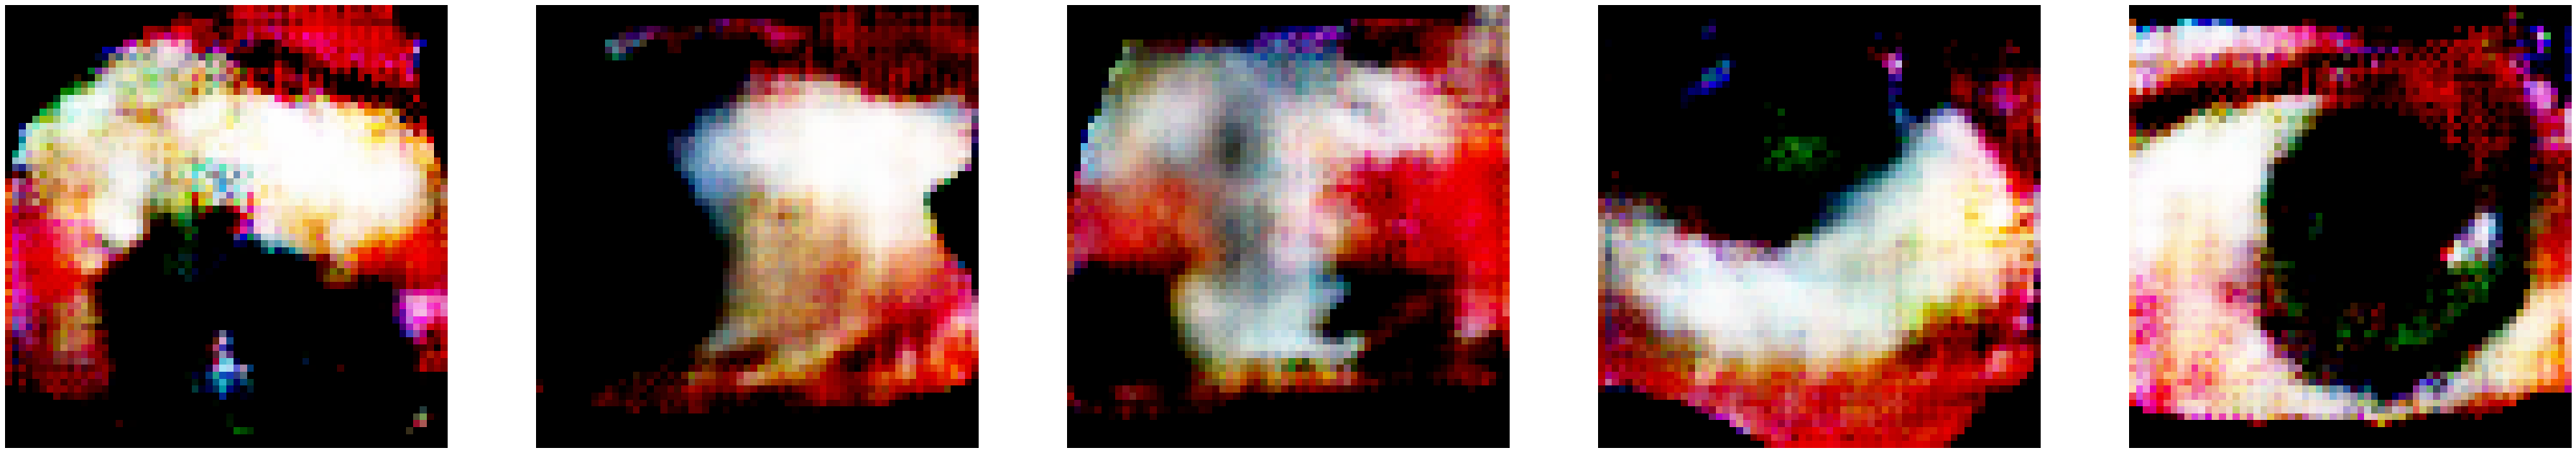

  0%|          | 0/250 [00:00<?, ?it/s]

[52/100][125/250] Loss_D: 1.2235 Loss_G: 0.9434 D(x): 0.5161 D(G(z)): 0.4126 / 0.3779
[52/100][250/250] Loss_D: 1.2364 Loss_G: 0.9960 D(x): 0.4841 D(G(z)): 0.3911 / 0.3526


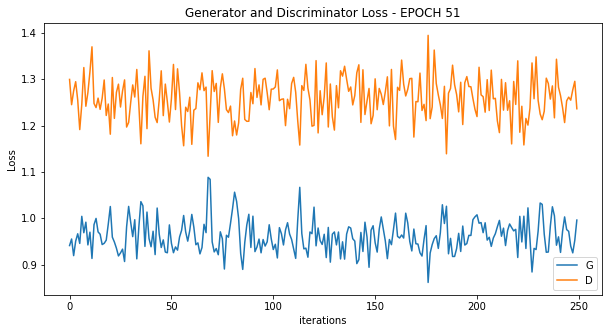

  0%|          | 0/250 [00:00<?, ?it/s]

[53/100][125/250] Loss_D: 1.2659 Loss_G: 0.9691 D(x): 0.4840 D(G(z)): 0.4068 / 0.3644
[53/100][250/250] Loss_D: 1.2671 Loss_G: 0.9596 D(x): 0.4699 D(G(z)): 0.3938 / 0.3678


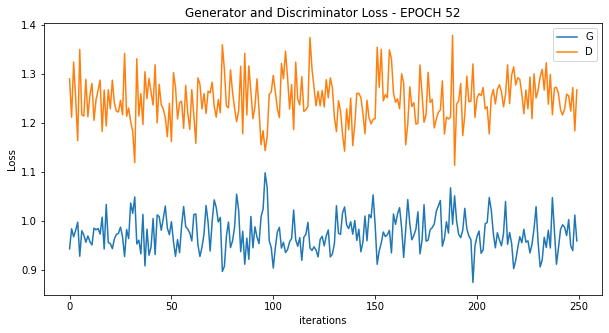

  0%|          | 0/250 [00:00<?, ?it/s]

[54/100][125/250] Loss_D: 1.2538 Loss_G: 0.9800 D(x): 0.4829 D(G(z)): 0.3958 / 0.3663
[54/100][250/250] Loss_D: 1.2187 Loss_G: 1.0295 D(x): 0.4802 D(G(z)): 0.3724 / 0.3405


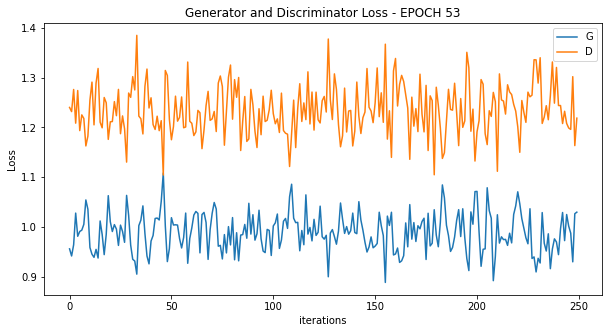

  0%|          | 0/250 [00:00<?, ?it/s]

[55/100][125/250] Loss_D: 1.1681 Loss_G: 1.0108 D(x): 0.5481 D(G(z)): 0.4015 / 0.3485
[55/100][250/250] Loss_D: 1.2508 Loss_G: 1.0182 D(x): 0.4991 D(G(z)): 0.4060 / 0.3476


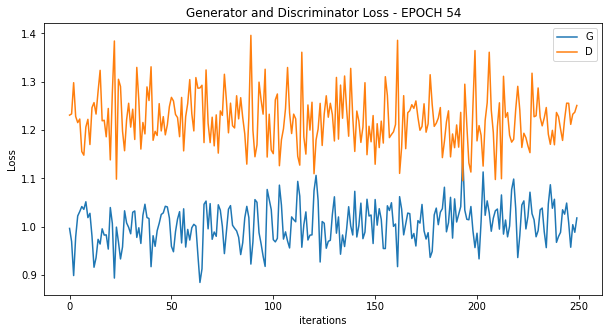

  0%|          | 0/250 [00:00<?, ?it/s]

[56/100][125/250] Loss_D: 1.2310 Loss_G: 1.0706 D(x): 0.4619 D(G(z)): 0.3624 / 0.3257
[56/100][250/250] Loss_D: 1.1053 Loss_G: 1.1015 D(x): 0.5654 D(G(z)): 0.3693 / 0.3186


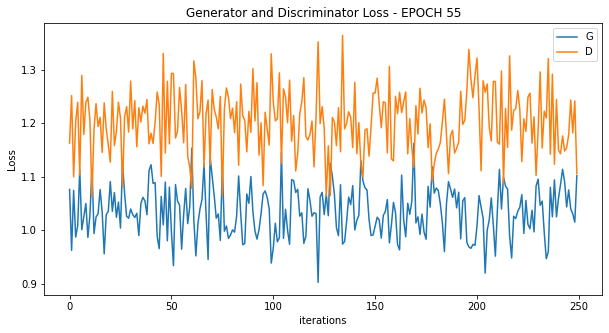

  0%|          | 0/250 [00:00<?, ?it/s]

[57/100][125/250] Loss_D: 1.2587 Loss_G: 1.0048 D(x): 0.4801 D(G(z)): 0.3887 / 0.3496
[57/100][250/250] Loss_D: 1.1533 Loss_G: 1.0314 D(x): 0.5317 D(G(z)): 0.3783 / 0.3424


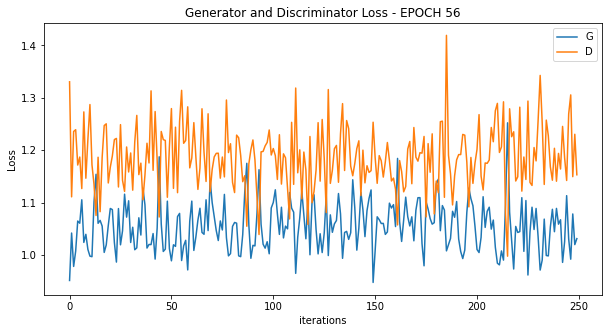

  0%|          | 0/250 [00:00<?, ?it/s]

[58/100][125/250] Loss_D: 1.0959 Loss_G: 1.1405 D(x): 0.5318 D(G(z)): 0.3391 / 0.3037
[58/100][250/250] Loss_D: 1.0010 Loss_G: 1.2501 D(x): 0.5658 D(G(z)): 0.3112 / 0.2721


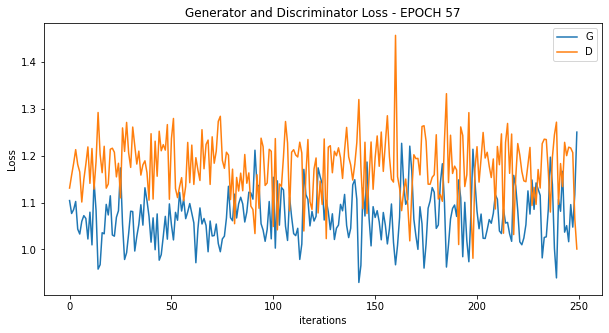

  0%|          | 0/250 [00:00<?, ?it/s]

[59/100][125/250] Loss_D: 1.1483 Loss_G: 1.0081 D(x): 0.5616 D(G(z)): 0.4021 / 0.3516
[59/100][250/250] Loss_D: 1.1302 Loss_G: 1.1764 D(x): 0.5476 D(G(z)): 0.3763 / 0.2950


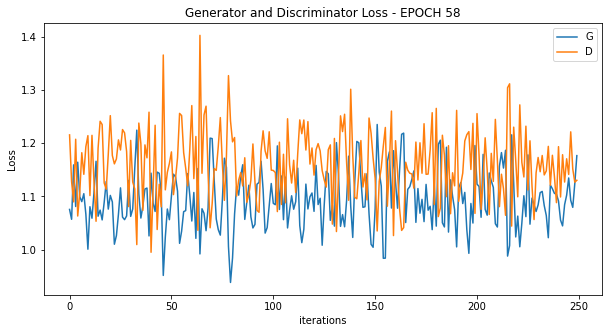

  0%|          | 0/250 [00:00<?, ?it/s]

[60/100][125/250] Loss_D: 1.2491 Loss_G: 0.9966 D(x): 0.5008 D(G(z)): 0.4001 / 0.3623
[60/100][250/250] Loss_D: 1.1018 Loss_G: 1.1866 D(x): 0.5248 D(G(z)): 0.3351 / 0.2914


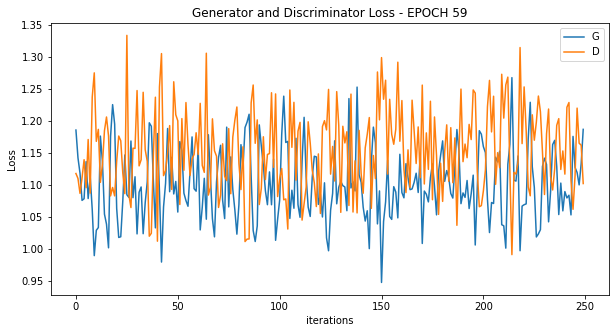

  0%|          | 0/250 [00:00<?, ?it/s]

[61/100][125/250] Loss_D: 1.1521 Loss_G: 1.1828 D(x): 0.5239 D(G(z)): 0.3558 / 0.2991
[61/100][250/250] Loss_D: 1.1794 Loss_G: 1.1701 D(x): 0.4911 D(G(z)): 0.3320 / 0.3021


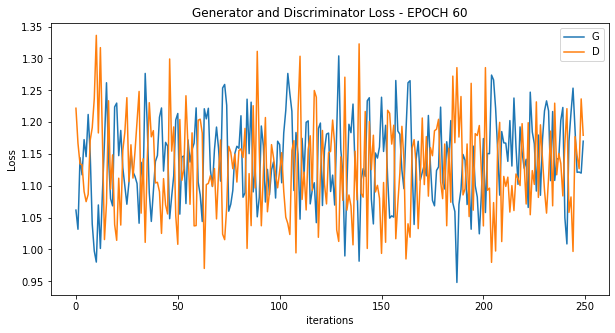

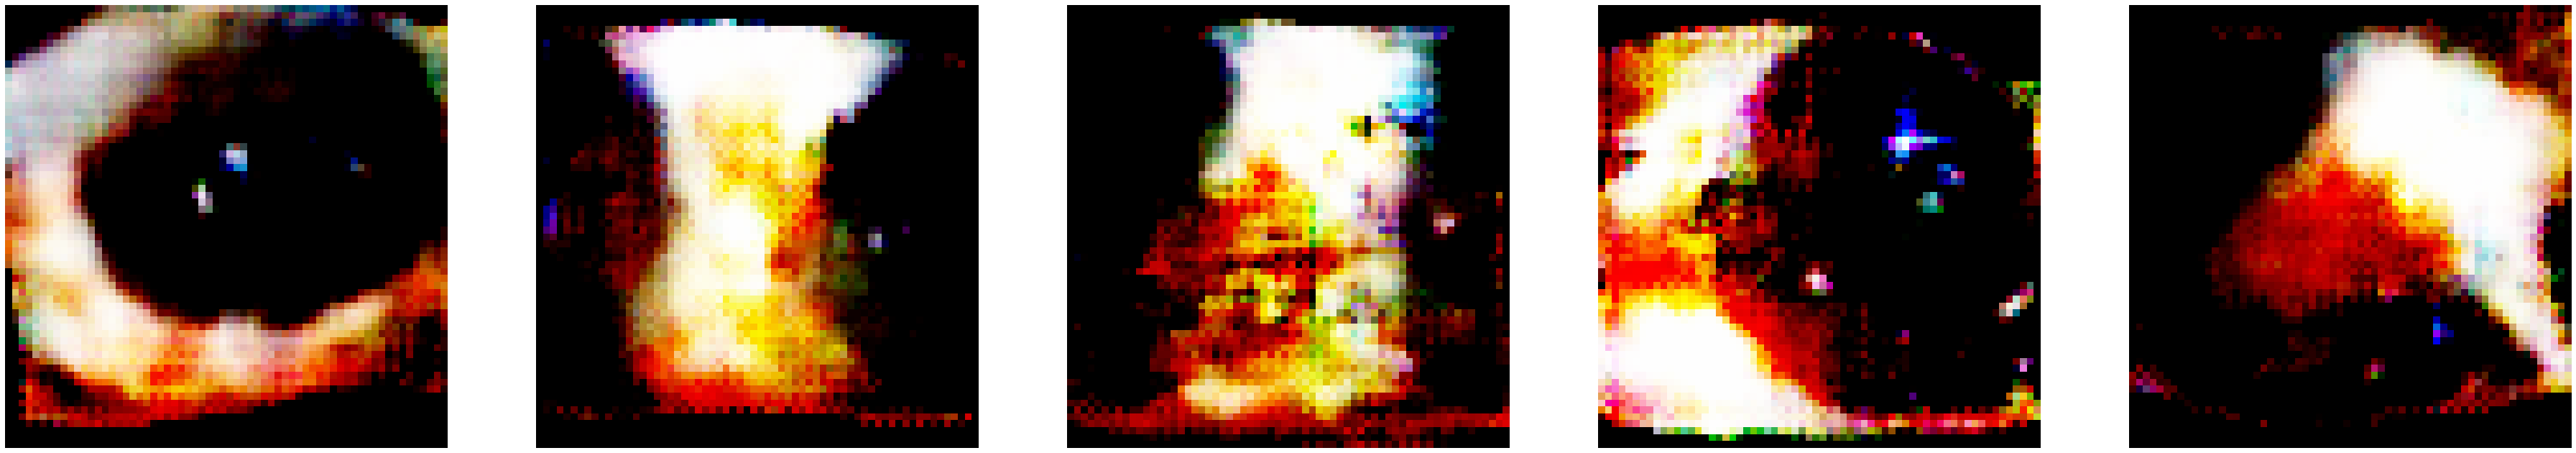

  0%|          | 0/250 [00:00<?, ?it/s]

[62/100][125/250] Loss_D: 1.0967 Loss_G: 1.1271 D(x): 0.5633 D(G(z)): 0.3567 / 0.3112
[62/100][250/250] Loss_D: 1.1532 Loss_G: 1.1187 D(x): 0.5352 D(G(z)): 0.3699 / 0.3132


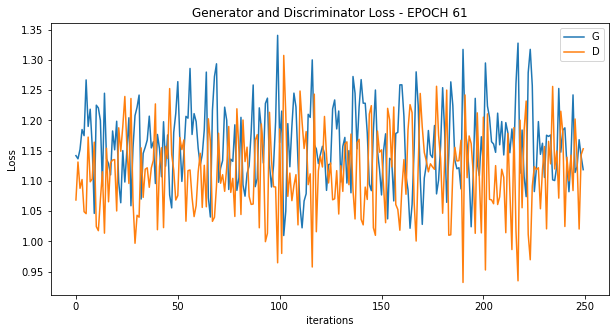

  0%|          | 0/250 [00:00<?, ?it/s]

[63/100][125/250] Loss_D: 1.1515 Loss_G: 1.1673 D(x): 0.4936 D(G(z)): 0.3368 / 0.2933
[63/100][250/250] Loss_D: 0.9983 Loss_G: 1.3189 D(x): 0.6163 D(G(z)): 0.3289 / 0.2454


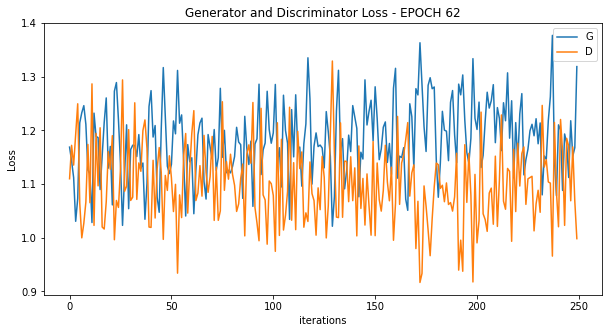

  0%|          | 0/250 [00:00<?, ?it/s]

[64/100][125/250] Loss_D: 1.0865 Loss_G: 1.2809 D(x): 0.5980 D(G(z)): 0.3749 / 0.2758
[64/100][250/250] Loss_D: 0.9908 Loss_G: 1.2577 D(x): 0.6128 D(G(z)): 0.3395 / 0.2733


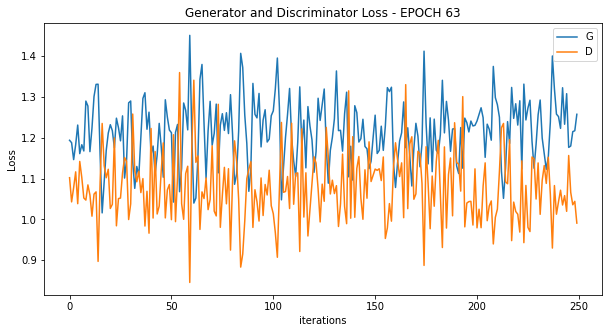

  0%|          | 0/250 [00:00<?, ?it/s]

[65/100][125/250] Loss_D: 1.0959 Loss_G: 1.2274 D(x): 0.5415 D(G(z)): 0.3309 / 0.2815
[65/100][250/250] Loss_D: 1.0683 Loss_G: 1.1863 D(x): 0.5659 D(G(z)): 0.3465 / 0.2949


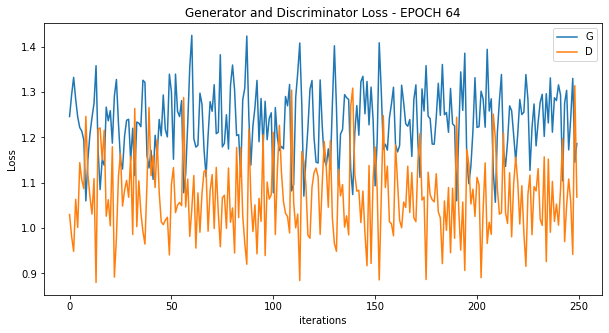

  0%|          | 0/250 [00:00<?, ?it/s]

[66/100][125/250] Loss_D: 1.0613 Loss_G: 1.2860 D(x): 0.5811 D(G(z)): 0.3372 / 0.2675
[66/100][250/250] Loss_D: 1.0219 Loss_G: 1.3814 D(x): 0.5753 D(G(z)): 0.3145 / 0.2572


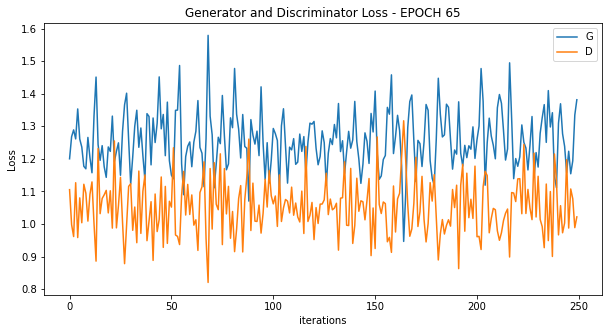

  0%|          | 0/250 [00:00<?, ?it/s]

[67/100][125/250] Loss_D: 0.9612 Loss_G: 1.3202 D(x): 0.6471 D(G(z)): 0.3431 / 0.2580
[67/100][250/250] Loss_D: 0.8996 Loss_G: 1.4833 D(x): 0.6700 D(G(z)): 0.3095 / 0.2166


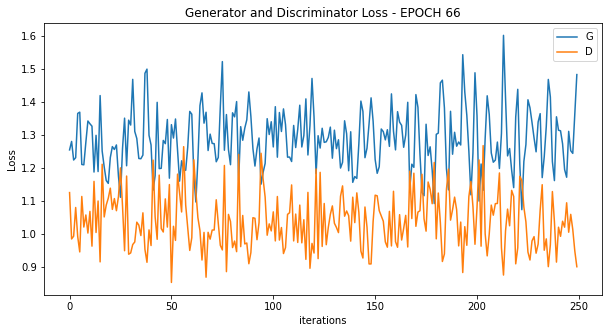

  0%|          | 0/250 [00:00<?, ?it/s]

[68/100][125/250] Loss_D: 0.9929 Loss_G: 1.3709 D(x): 0.5875 D(G(z)): 0.2849 / 0.2397
[68/100][250/250] Loss_D: 0.9185 Loss_G: 1.3821 D(x): 0.5796 D(G(z)): 0.2540 / 0.2378


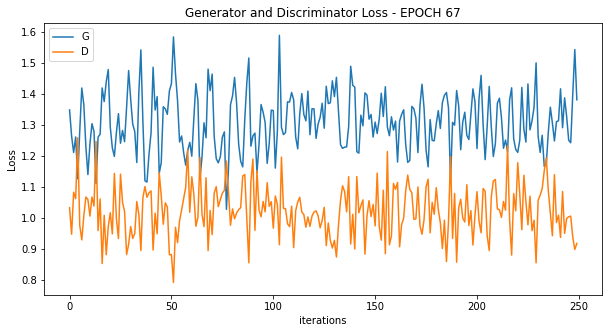

  0%|          | 0/250 [00:00<?, ?it/s]

[69/100][125/250] Loss_D: 1.0934 Loss_G: 1.3582 D(x): 0.4970 D(G(z)): 0.2808 / 0.2546
[69/100][250/250] Loss_D: 0.9531 Loss_G: 1.3653 D(x): 0.6272 D(G(z)): 0.3230 / 0.2393


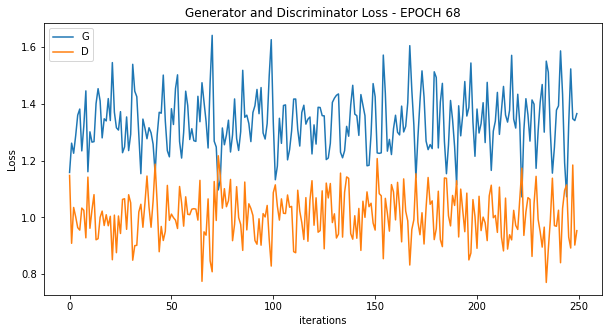

  0%|          | 0/250 [00:00<?, ?it/s]

[70/100][125/250] Loss_D: 1.0995 Loss_G: 1.1547 D(x): 0.5113 D(G(z)): 0.2992 / 0.3107
[70/100][250/250] Loss_D: 1.0171 Loss_G: 1.2943 D(x): 0.5855 D(G(z)): 0.3146 / 0.2783


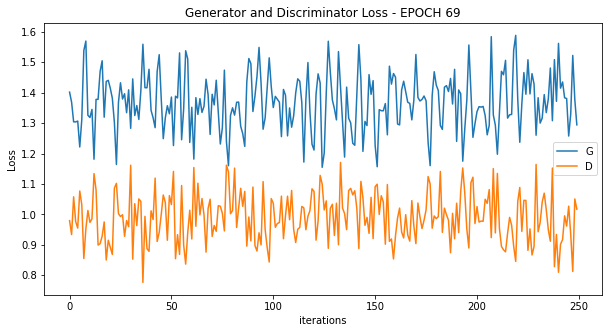

  0%|          | 0/250 [00:00<?, ?it/s]

[71/100][125/250] Loss_D: 0.8775 Loss_G: 1.4767 D(x): 0.6517 D(G(z)): 0.2803 / 0.2160
[71/100][250/250] Loss_D: 0.9217 Loss_G: 1.3839 D(x): 0.6681 D(G(z)): 0.3352 / 0.2476


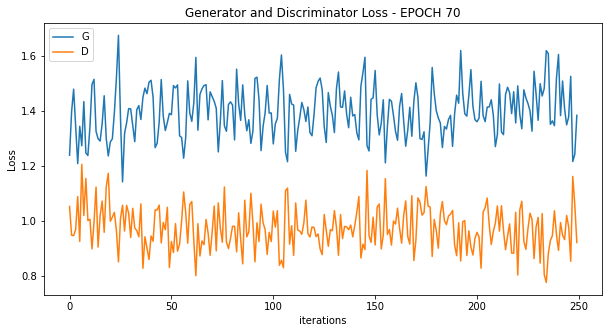

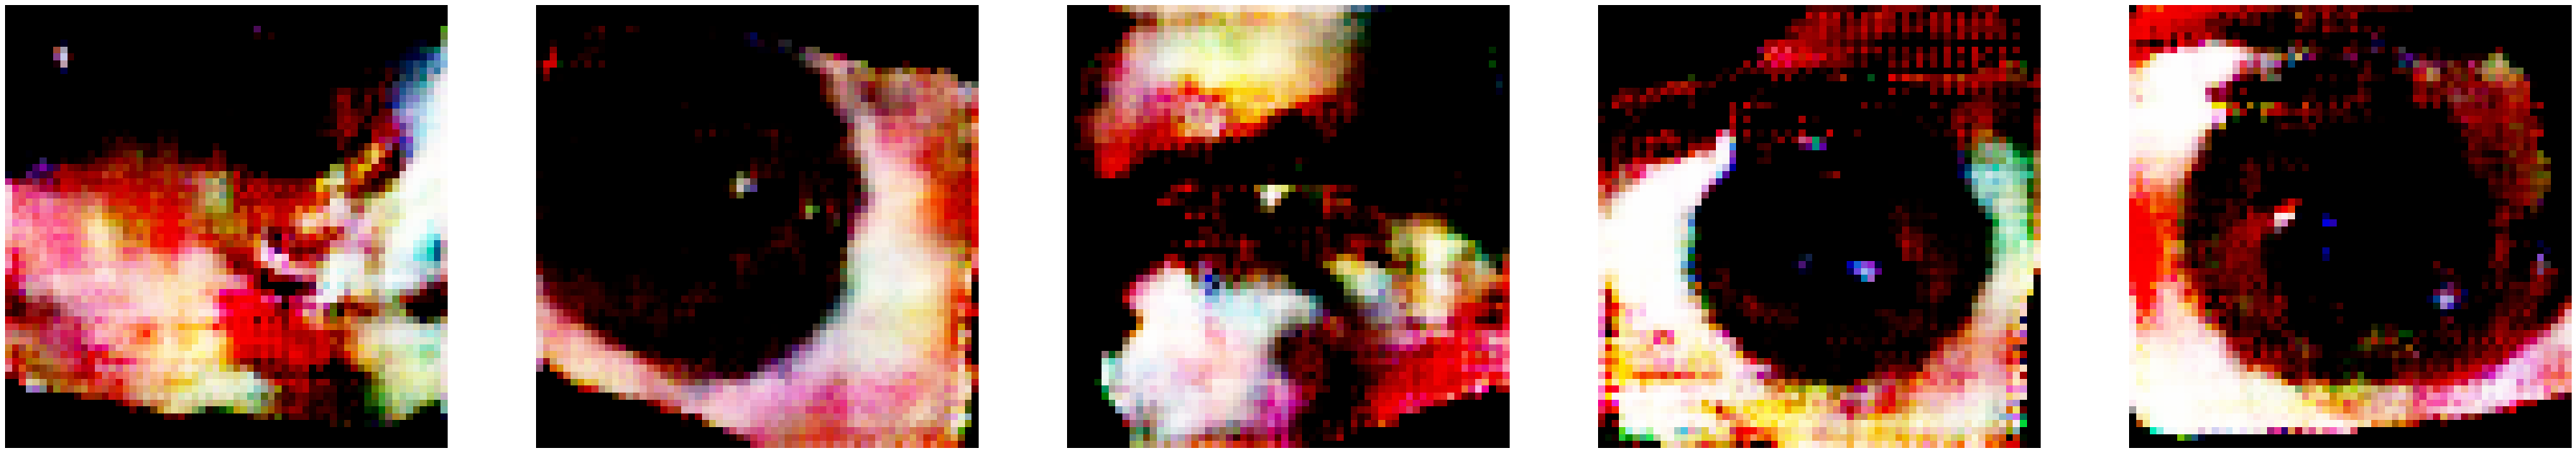

  0%|          | 0/250 [00:00<?, ?it/s]

[72/100][125/250] Loss_D: 0.9322 Loss_G: 1.4738 D(x): 0.6556 D(G(z)): 0.3306 / 0.2091
[72/100][250/250] Loss_D: 0.8972 Loss_G: 1.4490 D(x): 0.6257 D(G(z)): 0.2735 / 0.2238


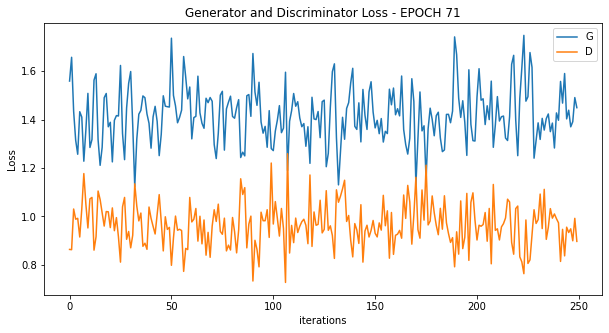

  0%|          | 0/250 [00:00<?, ?it/s]

[73/100][125/250] Loss_D: 0.9492 Loss_G: 1.3623 D(x): 0.6266 D(G(z)): 0.3070 / 0.2389
[73/100][250/250] Loss_D: 1.1975 Loss_G: 1.4009 D(x): 0.4250 D(G(z)): 0.2156 / 0.2416


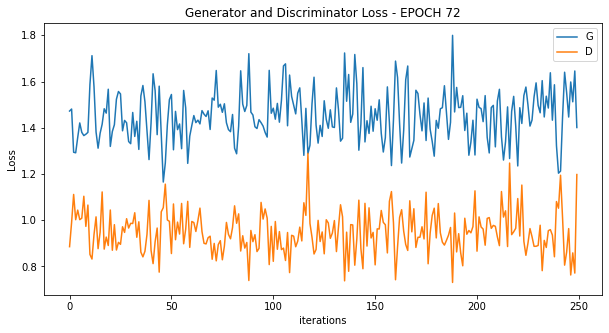

  0%|          | 0/250 [00:00<?, ?it/s]

[74/100][125/250] Loss_D: 1.0785 Loss_G: 1.4642 D(x): 0.4689 D(G(z)): 0.2239 / 0.2354
[74/100][250/250] Loss_D: 0.8574 Loss_G: 1.5428 D(x): 0.5849 D(G(z)): 0.2096 / 0.1940


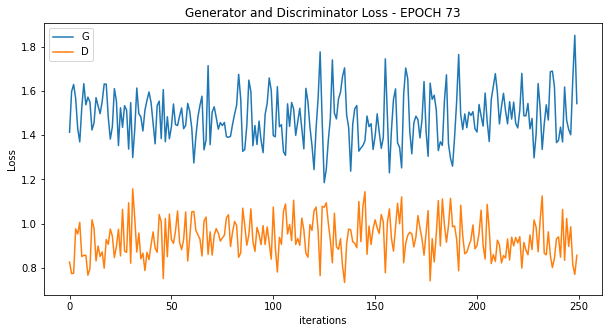

  0%|          | 0/250 [00:00<?, ?it/s]

[75/100][125/250] Loss_D: 1.0243 Loss_G: 1.3364 D(x): 0.6090 D(G(z)): 0.3236 / 0.2547
[75/100][250/250] Loss_D: 0.8987 Loss_G: 1.3526 D(x): 0.6364 D(G(z)): 0.2871 / 0.2514


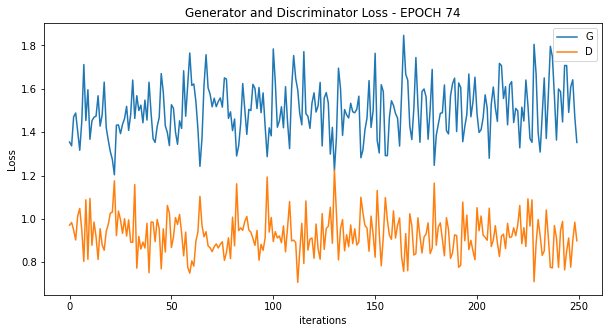

  0%|          | 0/250 [00:00<?, ?it/s]

[76/100][125/250] Loss_D: 0.8274 Loss_G: 1.6169 D(x): 0.6408 D(G(z)): 0.2302 / 0.1866
[76/100][250/250] Loss_D: 0.9531 Loss_G: 1.5209 D(x): 0.7255 D(G(z)): 0.3562 / 0.2175


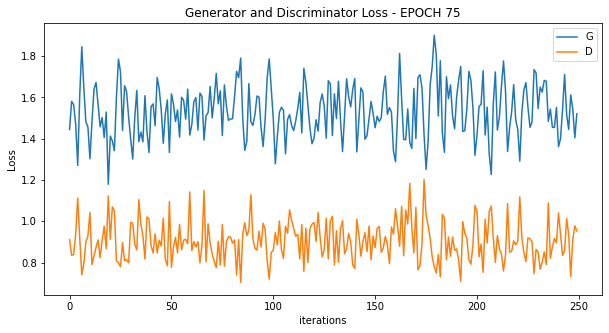

  0%|          | 0/250 [00:00<?, ?it/s]

[77/100][125/250] Loss_D: 1.1023 Loss_G: 1.4311 D(x): 0.4990 D(G(z)): 0.2796 / 0.2374
[77/100][250/250] Loss_D: 0.7394 Loss_G: 1.6343 D(x): 0.6984 D(G(z)): 0.2127 / 0.1820


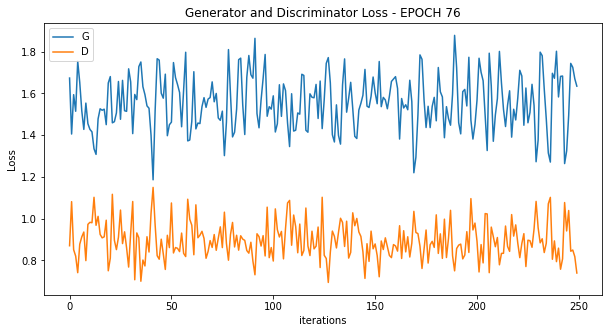

  0%|          | 0/250 [00:00<?, ?it/s]

[78/100][125/250] Loss_D: 0.7963 Loss_G: 1.6853 D(x): 0.7035 D(G(z)): 0.2575 / 0.1730
[78/100][250/250] Loss_D: 0.6960 Loss_G: 1.8864 D(x): 0.7070 D(G(z)): 0.1962 / 0.1408


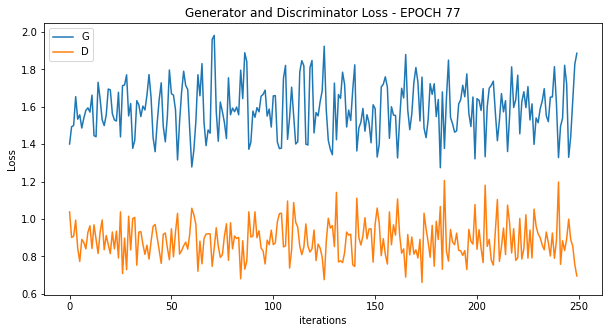

  0%|          | 0/250 [00:00<?, ?it/s]

[79/100][125/250] Loss_D: 0.8583 Loss_G: 1.6428 D(x): 0.6988 D(G(z)): 0.2936 / 0.1896
[79/100][250/250] Loss_D: 0.7253 Loss_G: 1.8285 D(x): 0.6552 D(G(z)): 0.1855 / 0.1538


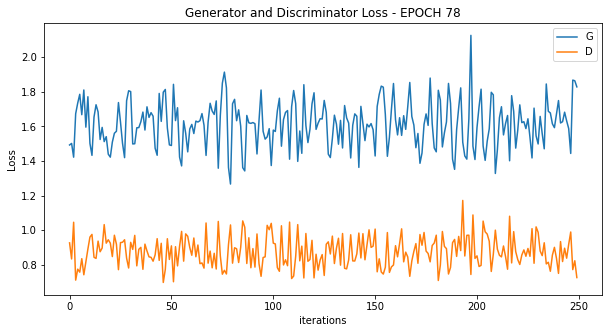

  0%|          | 0/250 [00:00<?, ?it/s]

[80/100][125/250] Loss_D: 0.8581 Loss_G: 1.5971 D(x): 0.6547 D(G(z)): 0.2531 / 0.2053
[80/100][250/250] Loss_D: 1.0486 Loss_G: 1.4470 D(x): 0.5537 D(G(z)): 0.2944 / 0.2297


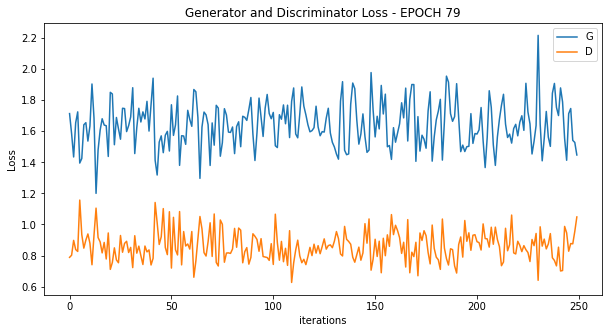

  0%|          | 0/250 [00:00<?, ?it/s]

[81/100][125/250] Loss_D: 0.9473 Loss_G: 1.5734 D(x): 0.6943 D(G(z)): 0.3408 / 0.2014
[81/100][250/250] Loss_D: 0.8520 Loss_G: 1.7225 D(x): 0.6372 D(G(z)): 0.2426 / 0.1895


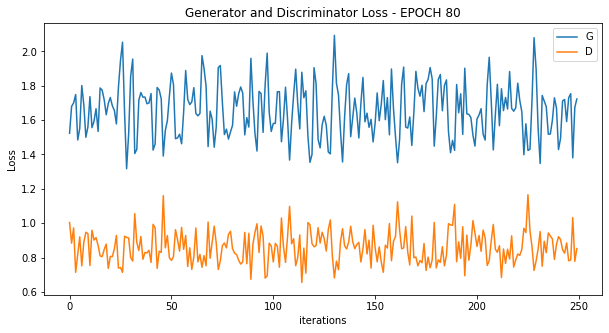

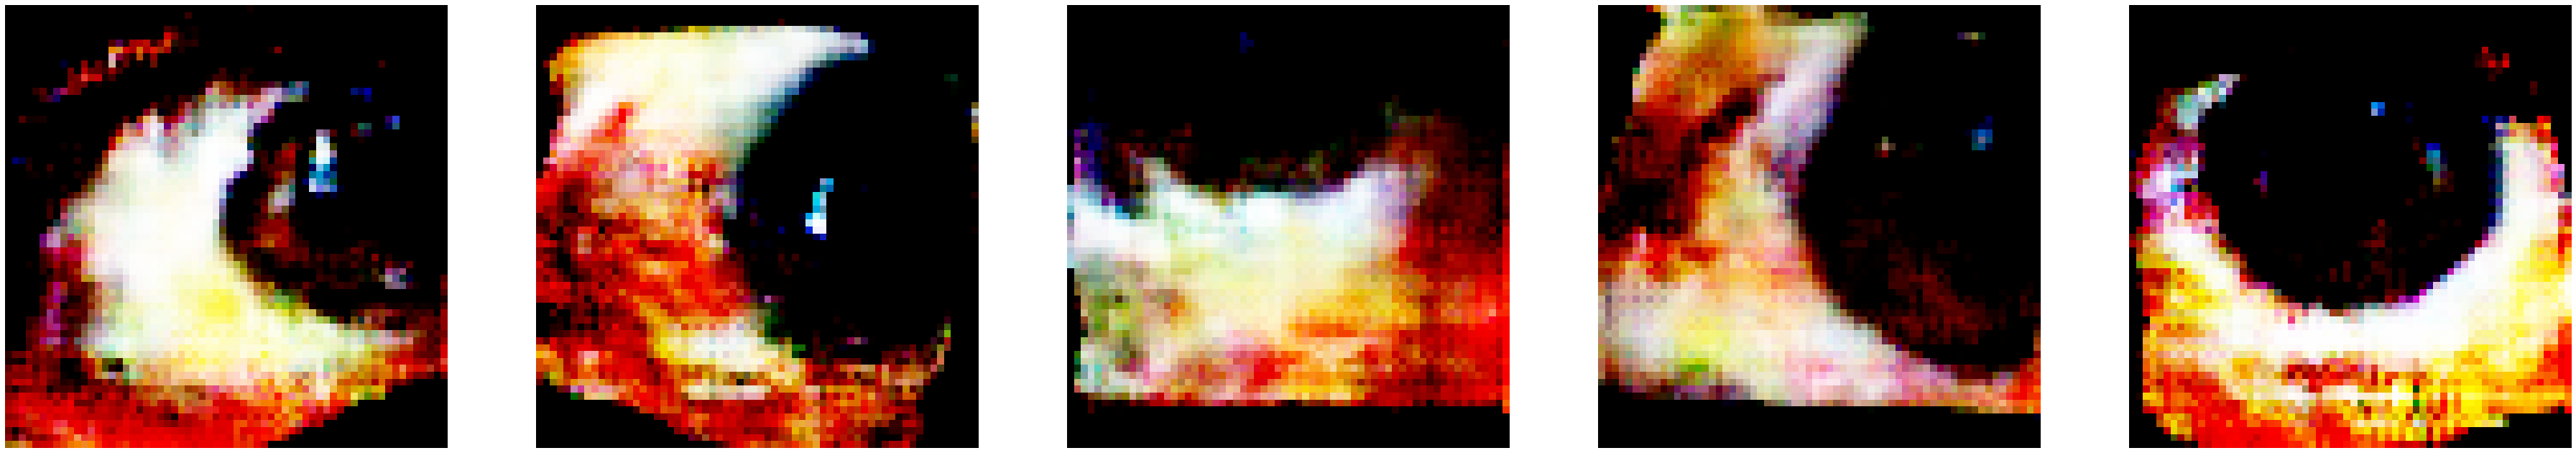

  0%|          | 0/250 [00:00<?, ?it/s]

[82/100][125/250] Loss_D: 0.8527 Loss_G: 1.5474 D(x): 0.7106 D(G(z)): 0.2878 / 0.2054
[82/100][250/250] Loss_D: 0.7532 Loss_G: 1.8009 D(x): 0.6785 D(G(z)): 0.1895 / 0.1601


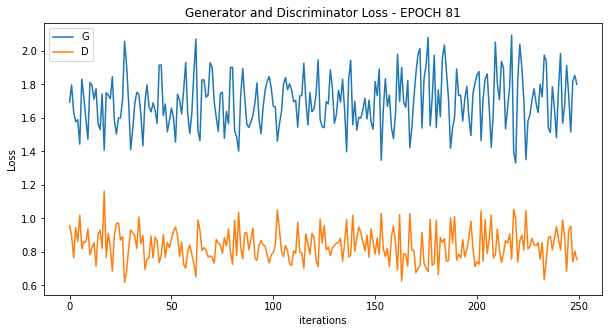

  0%|          | 0/250 [00:00<?, ?it/s]

[83/100][125/250] Loss_D: 0.8089 Loss_G: 1.6544 D(x): 0.7228 D(G(z)): 0.2772 / 0.1770
[83/100][250/250] Loss_D: 0.8237 Loss_G: 1.7501 D(x): 0.6715 D(G(z)): 0.2380 / 0.1729


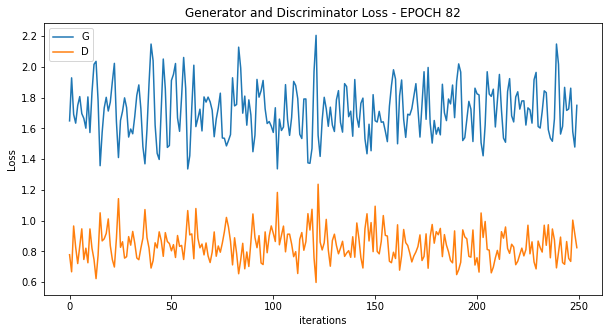

  0%|          | 0/250 [00:00<?, ?it/s]

[84/100][125/250] Loss_D: 0.7792 Loss_G: 2.0600 D(x): 0.6802 D(G(z)): 0.2141 / 0.1307
[84/100][250/250] Loss_D: 0.9332 Loss_G: 1.6857 D(x): 0.5637 D(G(z)): 0.2069 / 0.1715


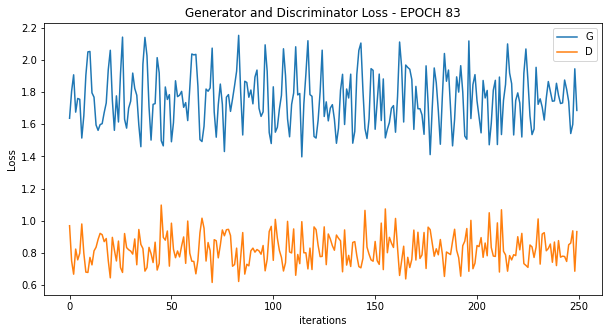

  0%|          | 0/250 [00:00<?, ?it/s]

[85/100][125/250] Loss_D: 0.7338 Loss_G: 2.0147 D(x): 0.6739 D(G(z)): 0.1727 / 0.1300
[85/100][250/250] Loss_D: 0.6205 Loss_G: 1.7178 D(x): 0.7919 D(G(z)): 0.1964 / 0.1671


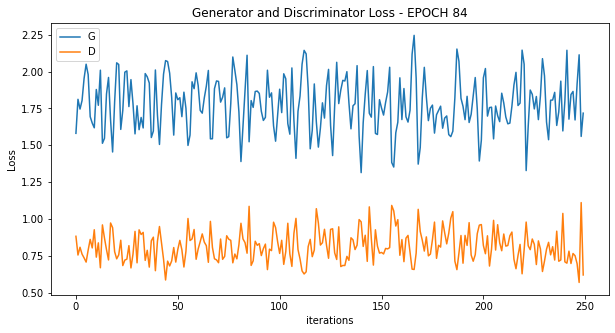

  0%|          | 0/250 [00:00<?, ?it/s]

[86/100][125/250] Loss_D: 0.8477 Loss_G: 1.8179 D(x): 0.6736 D(G(z)): 0.2242 / 0.1561
[86/100][250/250] Loss_D: 0.6284 Loss_G: 2.0736 D(x): 0.7358 D(G(z)): 0.1606 / 0.1190


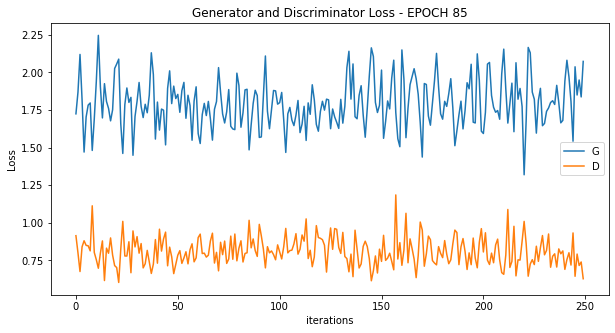

  0%|          | 0/250 [00:00<?, ?it/s]

[87/100][125/250] Loss_D: 0.8581 Loss_G: 1.5929 D(x): 0.6263 D(G(z)): 0.2352 / 0.2047
[87/100][250/250] Loss_D: 0.8379 Loss_G: 1.6280 D(x): 0.6351 D(G(z)): 0.2209 / 0.1963


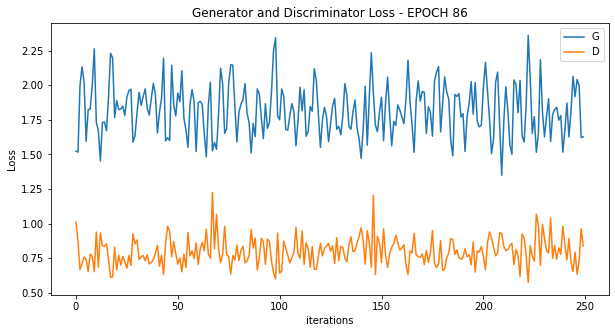

  0%|          | 0/250 [00:00<?, ?it/s]

[88/100][125/250] Loss_D: 0.9040 Loss_G: 1.8158 D(x): 0.5661 D(G(z)): 0.1700 / 0.1780
[88/100][250/250] Loss_D: 0.8080 Loss_G: 1.5971 D(x): 0.6253 D(G(z)): 0.2132 / 0.1953


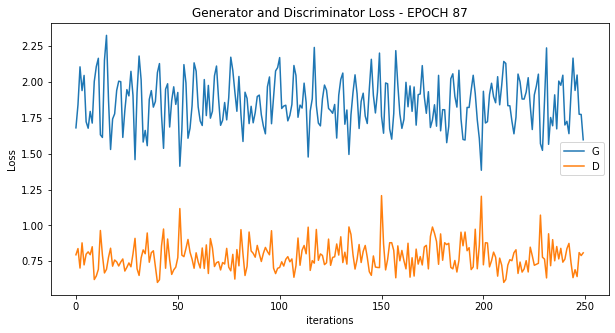

  0%|          | 0/250 [00:00<?, ?it/s]

[89/100][125/250] Loss_D: 0.7299 Loss_G: 1.7591 D(x): 0.6611 D(G(z)): 0.1769 / 0.1611
[89/100][250/250] Loss_D: 0.6938 Loss_G: 2.1705 D(x): 0.7616 D(G(z)): 0.2195 / 0.1116


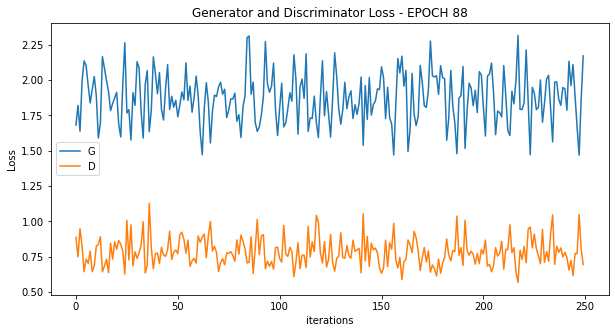

  0%|          | 0/250 [00:00<?, ?it/s]

[90/100][125/250] Loss_D: 0.7076 Loss_G: 1.7493 D(x): 0.6908 D(G(z)): 0.2027 / 0.1633
[90/100][250/250] Loss_D: 0.6749 Loss_G: 1.8433 D(x): 0.7358 D(G(z)): 0.1984 / 0.1547


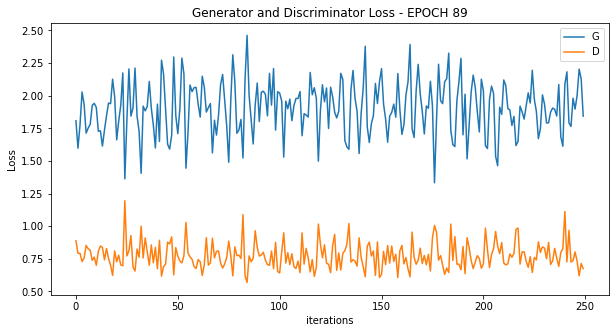

  0%|          | 0/250 [00:00<?, ?it/s]

[91/100][125/250] Loss_D: 0.6928 Loss_G: 1.9697 D(x): 0.7232 D(G(z)): 0.2037 / 0.1363
[91/100][250/250] Loss_D: 0.7560 Loss_G: 2.0510 D(x): 0.6996 D(G(z)): 0.1873 / 0.1277


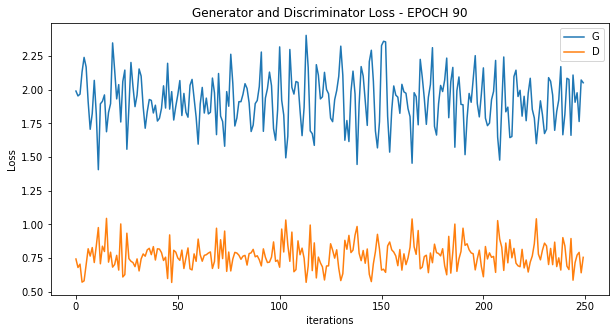

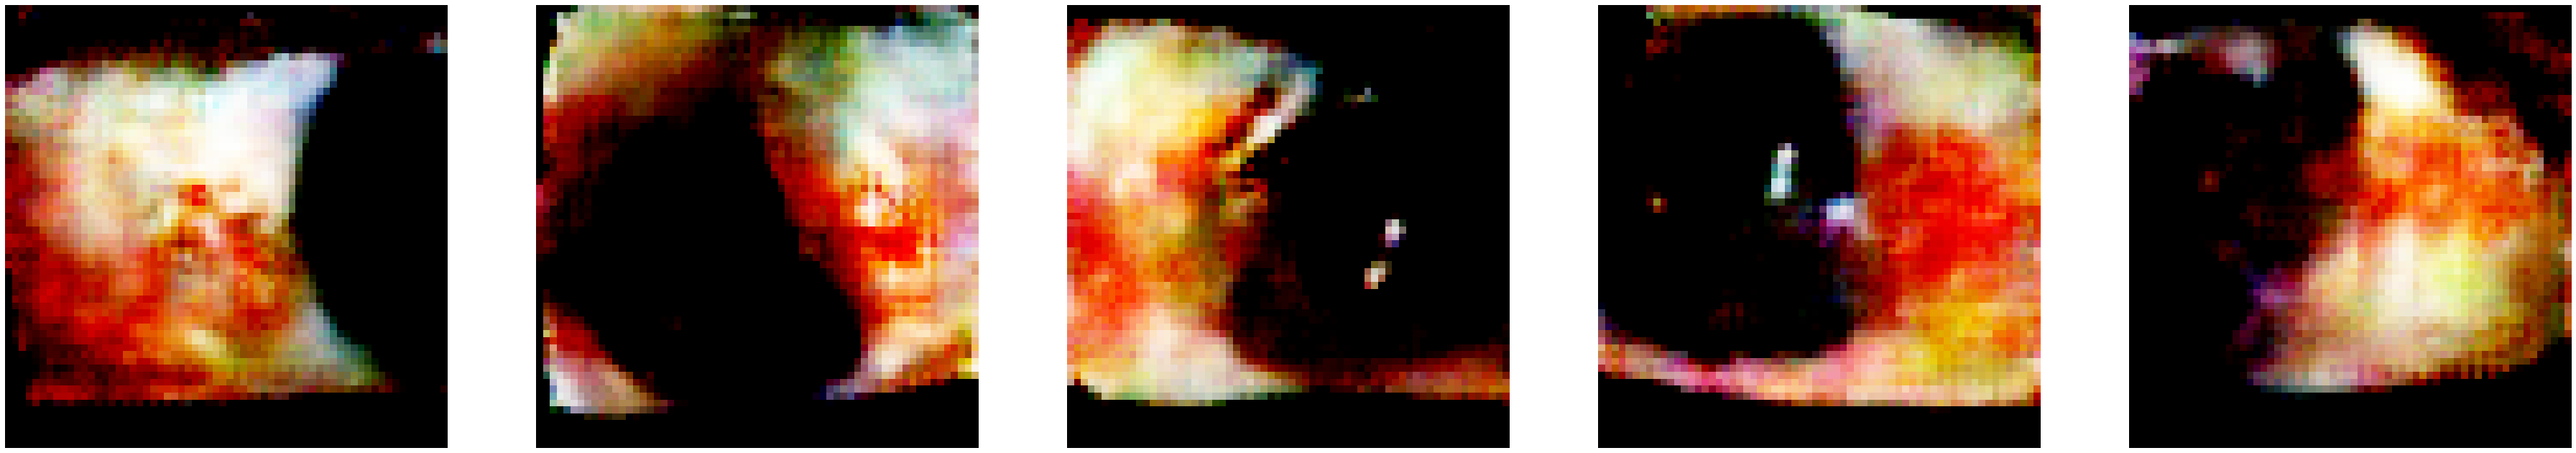

  0%|          | 0/250 [00:00<?, ?it/s]

[92/100][125/250] Loss_D: 0.8410 Loss_G: 2.3325 D(x): 0.5685 D(G(z)): 0.1033 / 0.0974
[92/100][250/250] Loss_D: 0.8355 Loss_G: 2.0065 D(x): 0.7877 D(G(z)): 0.3122 / 0.1366


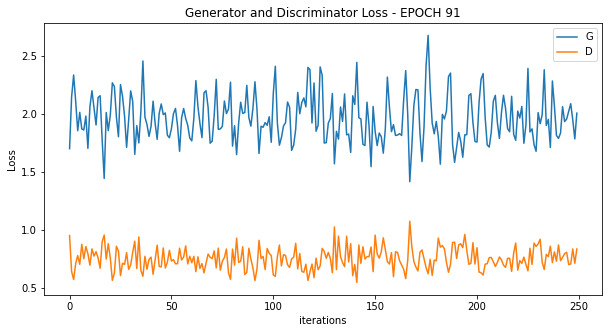

  0%|          | 0/250 [00:00<?, ?it/s]

[93/100][125/250] Loss_D: 0.7663 Loss_G: 2.0340 D(x): 0.6264 D(G(z)): 0.1647 / 0.1250
[93/100][250/250] Loss_D: 0.6565 Loss_G: 1.9373 D(x): 0.8313 D(G(z)): 0.2348 / 0.1285


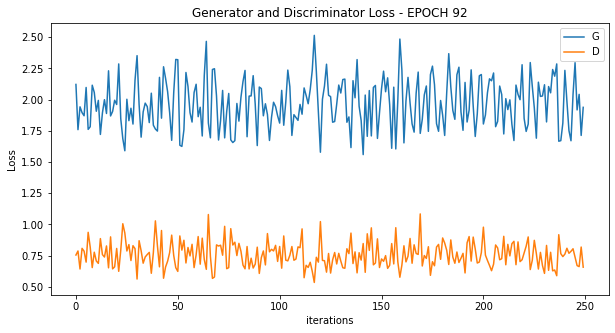

  0%|          | 0/250 [00:00<?, ?it/s]

[94/100][125/250] Loss_D: 0.7651 Loss_G: 1.7879 D(x): 0.6609 D(G(z)): 0.1828 / 0.1635
[94/100][250/250] Loss_D: 0.7270 Loss_G: 2.0738 D(x): 0.8292 D(G(z)): 0.2719 / 0.1151


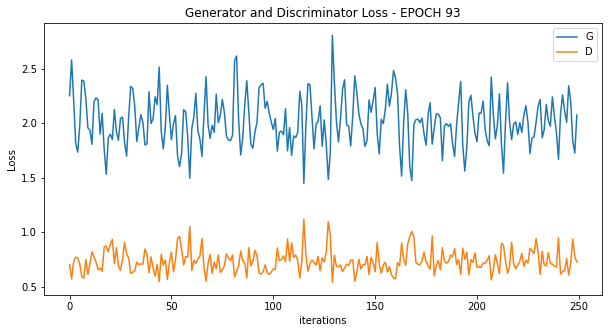

  0%|          | 0/250 [00:00<?, ?it/s]

[95/100][125/250] Loss_D: 0.6977 Loss_G: 2.0065 D(x): 0.7623 D(G(z)): 0.2086 / 0.1346
[95/100][250/250] Loss_D: 1.0103 Loss_G: 1.6384 D(x): 0.4980 D(G(z)): 0.1877 / 0.2016


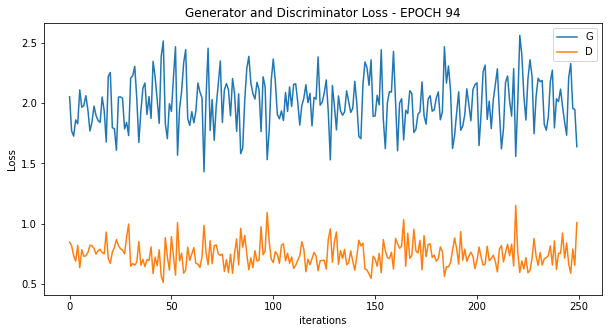

  0%|          | 0/250 [00:00<?, ?it/s]

[96/100][125/250] Loss_D: 0.6987 Loss_G: 2.0437 D(x): 0.6621 D(G(z)): 0.1496 / 0.1298
[96/100][250/250] Loss_D: 0.7137 Loss_G: 2.2423 D(x): 0.7036 D(G(z)): 0.1837 / 0.1094


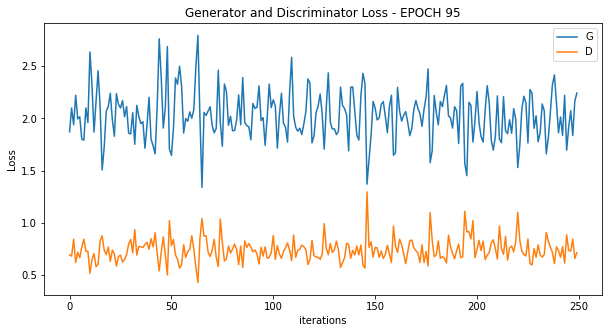

  0%|          | 0/250 [00:00<?, ?it/s]

[97/100][125/250] Loss_D: 0.7161 Loss_G: 2.2594 D(x): 0.6786 D(G(z)): 0.1454 / 0.1120
[97/100][250/250] Loss_D: 0.7189 Loss_G: 1.9739 D(x): 0.7228 D(G(z)): 0.2214 / 0.1296


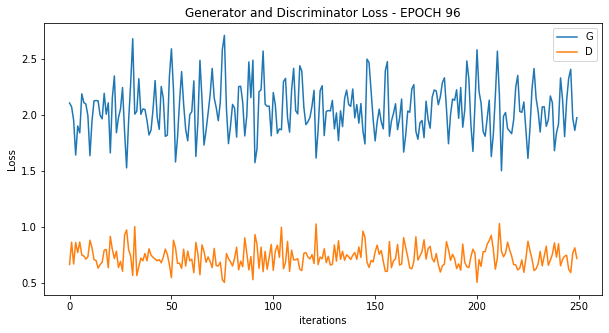

  0%|          | 0/250 [00:00<?, ?it/s]

[98/100][125/250] Loss_D: 0.6635 Loss_G: 2.2393 D(x): 0.7007 D(G(z)): 0.1283 / 0.1072
[98/100][250/250] Loss_D: 0.6685 Loss_G: 2.2757 D(x): 0.8079 D(G(z)): 0.2173 / 0.0949


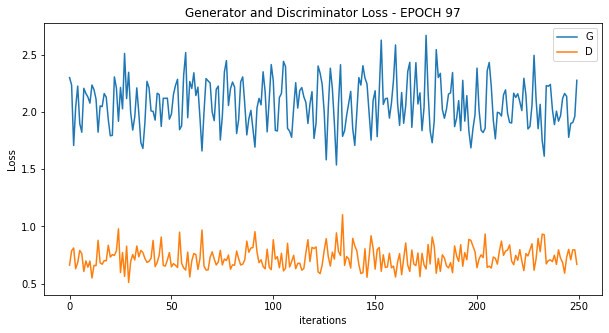

  0%|          | 0/250 [00:00<?, ?it/s]

[99/100][125/250] Loss_D: 0.6482 Loss_G: 2.2237 D(x): 0.7458 D(G(z)): 0.1457 / 0.1160
[99/100][250/250] Loss_D: 0.5853 Loss_G: 2.2464 D(x): 0.8092 D(G(z)): 0.1579 / 0.1034


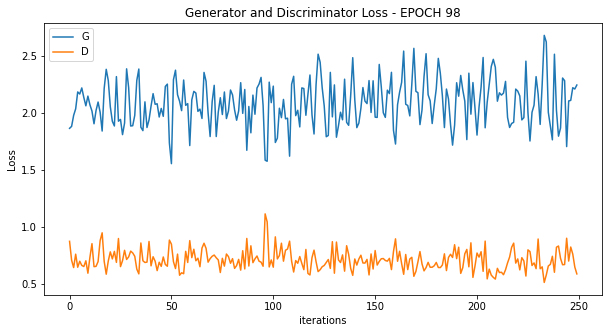

  0%|          | 0/250 [00:00<?, ?it/s]

[100/100][125/250] Loss_D: 0.6774 Loss_G: 1.9598 D(x): 0.6705 D(G(z)): 0.1253 / 0.1445
[100/100][250/250] Loss_D: 0.7434 Loss_G: 1.9646 D(x): 0.6178 D(G(z)): 0.1425 / 0.1396


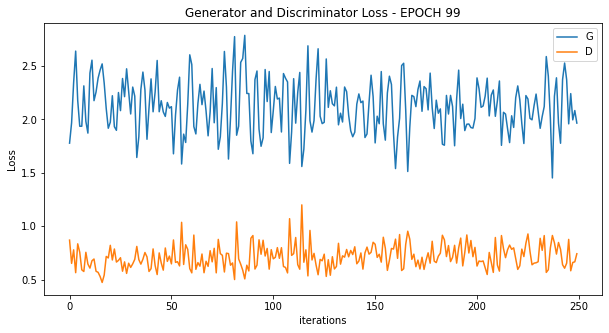

In [20]:
for epoch in range(epochs):
    
    start = time.time()
    for ii, (real_images, train_labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        netD.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)

        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        labels.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (ii+1) % (len(train_loader)//2) == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii+1, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
    plot_loss (G_losses, D_losses, epoch)
    G_losses = []
    D_losses = []
    if epoch % 10 == 0:
        show_generated_img()

    epoch_time.append(time.time()- start)
    
#             valid_image = netG(fixed_noise)